In [ ]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import os
import re

# Primary exploration: reproducibility.

The idea behind this notebook is to study the data and compare what we get by calculating things and the corresponding values stored in the repo.

Let's start by picking one of the TARA matrices stored in the repo.

In [ ]:
df1 = pd.read_csv('../01_data/02_satellite_data_processed/matrix_tara_world_adj_grids_25.tsv', sep='\t', index_col=0)
if 'IOP.aph_44' in df1.columns and 'bbp_unc_443' in df1.columns:
    df1 = df1.drop(columns = ['IOP.aph_44','bbp_unc_443'])

In [ ]:
df1

Now we define it's 'new' counterpart, obtained in 28/10 via the `00_00_extract_satellite_data.py` script. 

In [ ]:
df2 = pd.read_csv('../01_data/02_satellite_data_processed/matrix_tara_world_adj_grids_25_new.tsv', sep='\t', index_col=0)
if 'IOP.aph_44' in df2.columns and 'bbp_unc_443' in df2.columns:
    df2= df2.drop(columns = ['IOP.aph_44','bbp_unc_443'])

In [ ]:
df2


We start by checking the shape of the DataFrames match.

In [ ]:
(df1.columns == df2.columns).all()

Now we check the values are the same.

In [ ]:
diff = (df1.values - df2.values)

In [ ]:
total_err = diff.sum()
print(total_err)

In [ ]:
total_err/df1.values.shape[0]*df1.values.shape[1]

This is way too high, so lets dig into that error.

In [ ]:
idxs = diff.nonzero()

In [ ]:
idxs

In [ ]:
for k in range(len(idxs[0])):
    i = idxs[0][k]
    j = idxs[1][k]
    print(f" Difference at ({i},{j}) = {diff[i,j]}")

So there is only one 'big' error in the last element, meanwhile the rest can be attributed to float point. The numerical coordinates of the attribute are (79,31) as we can see above.

In [ ]:
df1.iloc[79].keys()[31]

So the problematic sample is `TSC280`, and the problematic feature is `PAR.par`. Looking at the individual values:

In [ ]:
print(f"Repo-stored value: {df1['PAR.par'].loc['TSC280']}.\nNew obtained value: {df2['PAR.par'].loc['TSC280']}.")

Let's try to recalculate this value 'by hand' and compare it to the two that we have. This will be done with the source code of the project.

In [ ]:
import numpy as np
import os
import re

def find_satellite_file(directory, pattern):
    regex = re.compile(pattern)
    for file in os.listdir(directory):
        if regex.match(file):
            return os.path.join(directory, file)
    return None

def select_n_nearest_valid(ds, feature, latitude, longitude, n):
    latitudes = ds['lat'].values
    longitudes = ds['lon'].values
    
    lat_grid, lon_grid = np.meshgrid(latitudes, longitudes, indexing='ij')
    distances = np.sqrt((lat_grid - latitude)**2 + (lon_grid - longitude)**2)
    
    sorted_indices = np.unravel_index(np.argsort(distances, axis=None), distances.shape)
    
    valid_points = []
    for i in range(len(sorted_indices[0])):
        lat_idx = sorted_indices[0][i]
        lon_idx = sorted_indices[1][i]
        data_point = ds[feature].isel(lat=lat_idx, lon=lon_idx)
        if not np.isnan(data_point.values):
            valid_points.append(data_point.values)
        if len(valid_points) >= n:
            break
    
    if len(valid_points) > 0:
        return np.mean(valid_points)
    else:
        return np.nan

In [ ]:
n = 25 #number of near points.
file_path = '../01_data/01_biological_data'
file_name = 'metadata.tsv'
sat_data_path = '../01_data/00_satellite_data'

output_dir = '../01_data/02_satellite_data_processed'
os.makedirs(output_dir, exist_ok=True)

file = os.path.join(file_path, file_name)
md = pd.read_csv(file, sep='\t', index_col=0)

md_srf = md[md.Layer == 'SRF'].copy()
md_srf['Event.date.YYYYMM'] = md_srf['Event.date'].str[:7].str.replace('-', '')
md_srf['Event.date.YYYYMM01'] = md_srf['Event.date'].str[:7].str.replace('-', '')+'01'

satellite_features = [
    'CHL.chlor_a', 'FLH.nflh', 'FLH.ipar', 'IOP.adg_unc_443', 'IOP.adg_443',
    'IOP.aph_unc_443', 'IOP.aph_44', 'IOP.bbp_s', 'IOP.adg_s', 'bbp_unc_443', 
    'IOP.bbp_443', 'IOP.a_412', 'IOP.a_443', 'IOP.a_469', 'IOP.a_488', 'IOP.a_531', 
    'IOP.a_547', 'IOP.a_555', 'IOP.a_645', 'IOP.a_667', 'IOP.a_678', 'IOP.bb_412', 
    'IOP.bb_443', 'IOP.bb_469', 'IOP.bb_488', 'IOP.bb_531', 'IOP.bb_547', 'IOP.bb_555', 
    'IOP.bb_645', 'IOP.bb_667', 'IOP.bb_678', 'KD.Kd_490', 'NSST.sst', 'PAR.par', 
    'PIC.pic', 'POC.poc', 'RRS.aot_869', 'RRS.angstrom', 'RRS.Rrs_412', 'RRS.Rrs_443', 
    'RRS.Rrs_469', 'RRS.Rrs_488', 'RRS.Rrs_531', 'RRS.Rrs_547', 'RRS.Rrs_555', 
    'RRS.Rrs_645', 'RRS.Rrs_667', 'RRS.Rrs_678', 'SST.sst'
]

satellite_data_terra = pd.DataFrame(index=md_srf.index, columns=satellite_features)
satellite_data_aqua = pd.DataFrame(index=md_srf.index, columns=satellite_features)

In [ ]:
row = md_srf.loc['TSC280'] #We use the obtained key.
feature = 'PAR.par' #We use the obtained feature.
latitude = row['Latitude']
longitude = row['Longitude']
date = row['Event.date.YYYYMM']
resolution = '9km'

In [ ]:
date

In [ ]:
feature

In [ ]:
pattern_terra = rf"TERRA_MODIS\.{date}01_{date}\d{{2}}\.L3m\.MO\.{feature}\.{resolution}\.nc"
file_path_terra = find_satellite_file(sat_data_path, pattern_terra)
pattern_aqua = rf"AQUA_MODIS\.{date}01_{date}\d{{2}}\.L3m\.MO\.{feature}\.{resolution}\.nc"
file_path_aqua = find_satellite_file(sat_data_path, pattern_aqua)

In [ ]:
ds_terra = xr.open_dataset(file_path_terra)
ds_aqua = xr.open_dataset(file_path_aqua)
terra_values = []
aqua_values = []
try:
    variable_name = feature.split('.')[1]
    
    data_point_terra = select_n_nearest_valid(ds_terra, variable_name, latitude, longitude, 25)
    terra_values.append(data_point_terra)

    data_point_aqua = select_n_nearest_valid(ds_aqua, variable_name, latitude, longitude, 25)
    aqua_values.append(data_point_aqua)

except KeyError:
    print(f"Feature {feature} not found in dataset")
finally:
    ds_terra.close()
    ds_aqua.close()

In [ ]:
aqua_arr = np.array(aqua_values)
terra_arr = np.array(terra_values)

In [ ]:
final_arr = (aqua_arr + terra_arr)*0.5

In [ ]:
print(f'Value by hand: {final_arr[0]}.\nValue stored in repo: {df1['PAR.par'].loc['TSC280']}. \nNew value obtained by script: {df2['PAR.par'].loc['TSC280']}.')

This means the value obtained by hand is closer to the '_new' value than to the one stored in the repo, with error likely of approximation. The difference of the old value and the new value is of order $10^{-3}$.

Now let us make a simmilar study to the `n=1` case: 

In [ ]:
df3 = pd.read_csv("../01_data/02_satellite_data_processed/matrix_tara_world_adj_grids_01.tsv", sep='\t', index_col=0)
if 'IOP.aph_44' in df3.columns and 'bbp_unc_443' in df3.columns:
    df3 = df3.drop(columns = ['IOP.aph_44','bbp_unc_443'])

In [ ]:
df3

Now we define it's 'new' counterpart, obtained in 28/10 via the `00_00_extract_satellite_data.py` script. 

In [ ]:
df4 = pd.read_csv('../01_data/02_satellite_data_processed/matrix_tara_world_adj_grids_01_new.tsv', sep='\t', index_col=0)
if 'IOP.aph_44' in df4.columns and 'bbp_unc_443' in df4.columns:
    df4= df4.drop(columns = ['IOP.aph_44','bbp_unc_443'])

In [ ]:
df4

We start by checking the shape of the DataFrames match.

In [ ]:
(df3.columns == df4.columns).all()

Now we check the values are the same.

In [ ]:
diff2 = (df3.values - df4.values)
print(diff2.max())
print(diff2.min())

In [ ]:
total_err2 = diff2.sum()
print(total_err2)

In this case, the values are all equal.

This gives the impression that the issue is somewhere between the part where the closest sat reads (physicall distance-wise) are chosen. There is a pending plan of testing with a third run. 

To investigate further one may plot the points selected in the proccess for both versions and check if they are the same or not.

It might also be related to eventual changes to the original database.

# Tarea: para mie. 6/nov
Repetir todo el proceso de clustering con TARA Chile desde cero. De momento esto contempla:
* Recuperar el `metadata_chile.tsv`.
* Re-escribir el script `00_00_extract_satellite_data.py` porque cambian varias keys.
* Unificar formato de fecha en el `metadata_chile.tsv`.

## Cosas tangenciales a las que ponerle tiempo si es posible.
* Estandarizar una pipeline que tome las keys como inputs.
* Documentar los módulos y funciones.

## Cluster projection on map
We need to study the behavior of the drawing code on the new data, since it has different format.

In [ ]:
input_dir = '../03_results/out_genomic_clusters'
filename = 'kmeans_results_ch.tsv'

env_data_dir = '../01_data/01_biological_data'
env_filename = 'metadata_chile.tsv'

output_dir = '../03_results/out_genomic_clusters/map_projections_ch'
os.makedirs(output_dir, exist_ok=True)

file_path = os.path.join(input_dir,filename)
md_path = os.path.join(env_data_dir,env_filename)

clusters = pd.read_csv(file_path, sep='\t', index_col=0)
for col in clusters.columns:
    clusters[col] = clusters[col].astype('Int64')
md = pd.read_csv(md_path, sep='\t', index_col=0)

In [ ]:
col_selection = ['lat_cast','lon_cast','Temperature [ºC]',
       'Salinity [PSU]', 'Oxygen [%]',
       'Fluorescence [mg/m3]', 'Orthophosphate [uM]', 'Silicic-acid [uM]',
       'Nitrite [uM]', 'Nitrates [uM]', 'NP ratio']

In [ ]:
merged_data = md.join(clusters)

In [ ]:
def plot_clusters_on_map(merged_data, cluster_column):
    filtered_data = merged_data[~merged_data[cluster_column].isna()] # filter out rows where cluster_column is NaN
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 18), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()  # flatten the array of axes for easy iteration
    
    plot_titles = [
        f'Clusters Projection: {cluster_column}',
        'Temperature [ºC]',
       'Salinity [PSU]', 'Oxygen [%]',
       'Fluorescence [mg/m3]', 'Orthophosphate [uM]', 'Silicic-acid [uM]',
       'Nitrite [uM]', 'Nitrates [uM]', 'NP ratio'
    ]
    data_columns = [
        cluster_column,
        'Temperature [ºC]',
       'Salinity [PSU]', 'Oxygen [%]',
       'Fluorescence [mg/m3]', 'Orthophosphate [uM]', 'Silicic-acid [uM]',
       'Nitrite [uM]', 'Nitrates [uM]', 'NP ratio'
    ]
    
    unique_clusters = filtered_data[cluster_column].unique()
    num_clusters = len(unique_clusters)
    marker_styles = ['o', 's', '^', 'v', '<', '>', 'd', 'p', 'h', 'H', '*', 'x', '+', 'D']
    if num_clusters > len(marker_styles):
        marker_styles = (marker_styles * ((num_clusters // len(marker_styles)) + 1))[:num_clusters]
    cluster_marker_map = dict(zip(unique_clusters, marker_styles))
    
    env_vars = ['Temperature [ºC]',
       'Salinity [PSU]', 'Oxygen [%]',
       'Fluorescence [mg/m3]', 'Orthophosphate [uM]', 'Silicic-acid [uM]',
       'Nitrite [uM]', 'Nitrates [uM]', 'NP ratio']
    norms = {}
    
    for data_column in env_vars:
        vmin = filtered_data[data_column].min()
        vmax = filtered_data[data_column].max()
        norms[data_column] = Normalize(vmin=vmin, vmax=vmax)
    
    for idx, ax in enumerate(axes):
        ax.set_extent([-80, -67, -55,-17])

        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.BORDERS)
        
        ax.set_title(plot_titles[idx])
        
        data_column = data_columns[idx]
        plot_data = filtered_data[~filtered_data[data_column].isna()]
        
        if idx == 0:
            for cluster_id in unique_clusters:
                cluster_points = plot_data[plot_data[cluster_column] == cluster_id]
                ax.scatter(
                    cluster_points['lon_cast'],
                    cluster_points['lat_cast'],
                    label=f'Cluster {cluster_id}',
                    s=35,
                    marker=cluster_marker_map[cluster_id],
                    transform=ccrs.PlateCarree()
                )
            ax.legend(loc='upper left')
        else:
            norm = norms[data_column]
            for cluster_id in unique_clusters:
                cluster_points = plot_data[plot_data[cluster_column] == cluster_id]
                sc = ax.scatter(
                    cluster_points['lon_cast'],
                    cluster_points['lat_cast'],
                    c=cluster_points[data_column],
                    s=35,
                    cmap='viridis',
                    marker=cluster_marker_map[cluster_id],
                    edgecolors='black',
                    norm=norm,
                    transform=ccrs.PlateCarree()
                )
            cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.5)
            cbar.set_label(data_column)
            handles = []
            for cluster_id in unique_clusters:
                marker = cluster_marker_map[cluster_id]
                handle = plt.Line2D([], [], color='black', marker=marker, linestyle='', markersize=8, label=f'Cluster {cluster_id}')
                handles.append(handle)
            ax.legend(handles=handles, loc='upper left')
    
    plt.tight_layout()
    
    output_path = os.path.join(output_dir, f'clusters_{cluster_column}.pdf')
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    plt.close()

In [ ]:
for column in clusters.columns:
    plot_clusters_on_map(merged_data, column)

## Comparativa de técnicas

Para mañana: doble plan de acción.
* Tomar los clusters viejos y de ahí filtrar y mapear. ('Más fácil capaz') (esto ya está básicamente hechp)
* Filtrar, clusterizar, y mapear. (Aprovecha que se quita una 'variable' de la clusterización):
    * En vez de leer las matrices de clusters, leer las matrices de data bio
* Comparar como lucen

La nomenclatura será, en el mismo orden:
* `_cf`: clustered filtered.
* `_fc`: filtered clustered.

### 1.- Cluster -> Filtro

#### Data generation.
This code right ahead takes all the already clustered data, and saves a file of the selection of those samples that are 'SRF'. If a file named `kmeans_results_ch_srf_clustered_filtered.tsv` exists already in the folder, there is no need to run this code.

In [ ]:
input_dir = '../03_results/out_genomic_clusters'
filename = 'kmeans_results_ch.tsv'


output_dir = '../03_results/out_genomic_clusters/map_projections_ch'
os.makedirs(output_dir, exist_ok=True)

file_path = os.path.join(input_dir,filename)


In [ ]:
input_dir = '../01_data/01_biological_data'
output_dir = '../03_results/out_genomic_clusters'
os.makedirs(output_dir, exist_ok=True)

# Read matrices of interest and sort them alphabetically
files = os.listdir(input_dir)
matrix_files = sorted([f for f in files if f.startswith('Matrix_chile_GEN_') and f.endswith('.tsv')])

In [ ]:
for file in matrix_files:
    pth = f"{input_dir}/{file}"
    #bio_mtrx es en verdad cluster_mtrx. Arreglar para legibilidad.
    clstr_mtrx =  pd.read_csv(file_path, sep='\t', index_col=0) 
    meta_mtrx = pd.read_csv('../01_data/01_biological_data/metadata_chile.tsv', sep='\t', index_col=0) 
    meta_mtrx = meta_mtrx[meta_mtrx['Depth level']== 'SRF']
    dirty_df = meta_mtrx.join(clstr_mtrx)
    clean_df = dirty_df.drop(meta_mtrx.columns, axis=1)
    new_keys = {col: col+'_cf' for col in clean_df.columns}
    clean_df.rename(columns = new_keys, inplace=True)
    output_filename = 'kmeans_results_ch_srf_clustered_filtered.tsv'
    clean_df.to_csv(os.path.join(output_dir, output_filename), sep='\t', index=True)

#### Plotting

In [ ]:
input_dir = '../03_results/out_genomic_clusters'
filename = 'kmeans_results_ch_srf_clustered_filtered.tsv'

env_data_dir = '../01_data/01_biological_data'
env_filename = 'metadata_chile.tsv'

output_dir = '../03_results/out_genomic_clusters/map_projections_ch'
os.makedirs(output_dir, exist_ok=True)

file_path = os.path.join(input_dir,filename)
md_path = os.path.join(env_data_dir,env_filename)

clusters = pd.read_csv(file_path, sep='\t', index_col=0)
for col in clusters.columns:
    clusters[col] = clusters[col].astype('Int64')
md = pd.read_csv(md_path, sep='\t', index_col=0)

In [ ]:
col_selection = ['lat_cast','lon_cast','Temperature [ºC]',
       'Salinity [PSU]', 'Oxygen [%]',
       'Fluorescence [mg/m3]', 'Orthophosphate [uM]', 'Silicic-acid [uM]',
       'Nitrite [uM]', 'Nitrates [uM]', 'NP ratio']

In [ ]:
merged_data = clusters.join(md)

In [ ]:
for column in clusters.columns:
    plot_clusters_on_map(merged_data, column)

### 2.- Filtro -> Cluster

#### Data collection
We start by collecting the bio data, filtering only the SRF samples, and saving the resulting matrices.

In [ ]:
md_dir = '../01_data/01_biological_data'
md_filename = 'metadata_chile.tsv'
md_path = os.path.join(md_dir,md_filename)
md = pd.read_csv(md_path, sep='\t', index_col=0)

output_dir = md_dir 


In [ ]:
md_clean = md[md['Depth level']=='SRF']

In [ ]:
# Read matrices of interest and sort them alphabetically
files = os.listdir(md_dir)
matrix_files = sorted([f for f in files if f.startswith('Matrix_chile_GEN_') and f.endswith('.tsv')])

In [ ]:
matrix_files

In [ ]:
for name in matrix_files:
    print(f"filtering {name}")
    file_path = os.path.join(md_dir, name)
    matrix = pd.read_csv(file_path, sep='\t', index_col=0)
    clean_matrix = md_clean.join(matrix).drop(md_clean.columns,axis = 1)
    output_filename =  name[:-8] + '_srf.tsv'
    clean_matrix.to_csv(os.path.join(output_dir, output_filename), sep='\t', index=True)

#### Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [ ]:
# CLR implementation
def clr_(data, eps=1e-6):
    """
    Perform centered log-ratio (clr) normalization on a dataset.

    Parameters:
    data (pandas.DataFrame): A DataFrame with samples as rows and components as columns.

    Returns:
    pandas.DataFrame: A clr-normalized DataFrame.
    """
    if (data < 0).any().any():
        raise ValueError("Data should be strictly positive for clr normalization.")

    # Add small amount to cells with a value of 0
    if (data <= 0).any().any():
        data = data.replace(0, eps)

    # Calculate the geometric mean of each row
    gm = np.exp(data.apply(np.log).mean(axis=1))

    # Perform clr transformation
    clr_data = data.apply(np.log).subtract(np.log(gm), axis=0)

    return clr_data

all_metrics_results = []
clustering_results_dict = {}

def perform_kmeans_clustering(matrix, matrix_type_subsample, n_clusters_list, clr=False):
    suffix = 'clr_' if clr else ''
    # Perform K-Means for different 'n'
    for n_clusters in n_clusters_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=50)
        kmeans.fit(matrix)
        
        cluster_labels = kmeans.labels_
        
        # Calculate evaluation metrics
        inertia = kmeans.inertia_
        silhouette_avg = silhouette_score(matrix, cluster_labels)
        davies_bouldin = davies_bouldin_score(matrix, cluster_labels)
        calinski_harabasz = calinski_harabasz_score(matrix, cluster_labels)
        
        all_metrics_results.append({
            'matrix': f"{suffix}{matrix_type_subsample}",
            'n_clusters': n_clusters,
            'inertia': inertia,
            'silhouette_score': silhouette_avg,
            'davies_bouldin_score': davies_bouldin,
            'calinski_harabasz_score': calinski_harabasz
        })
        
        col_name = f"{suffix}{matrix_type_subsample}_kmeans_{n_clusters}" # Create a DataFrame for the cluster labels with appropriate column names
        results = pd.DataFrame({col_name: cluster_labels}, index=matrix.index)
        
        if col_name not in clustering_results_dict:
            clustering_results_dict[col_name] = results
        else:
            clustering_results_dict[col_name] = pd.concat([clustering_results_dict[col_name], results], axis=1)


In [ ]:
input_dir = '../01_data/01_biological_data'
output_dir = '../03_results/out_genomic_clusters'
os.makedirs(output_dir, exist_ok=True)

# Read matrices of interest and sort them alphabetically
files = os.listdir(input_dir)
matrix_files = sorted([f for f in files if f.startswith('Matrix_chile_GEN_') and f.endswith('_srf.tsv')])

# Perform K-Means for different n-clusters for each matrix
n_clusters_list = [3, 4, 5, 6, 7, 8]
for matrix_file in matrix_files:
    print(f"performing k-means to {matrix_file}")
    file_path = os.path.join(input_dir, matrix_file)
    matrix = pd.read_csv(file_path, sep='\t', index_col=0)
    base_filename = os.path.splitext(os.path.basename(file_path))[0]
    matrix_type_subsample = "_".join(base_filename.split('_')[3:])
    
    perform_kmeans_clustering(matrix, matrix_type_subsample, n_clusters_list, clr=False)
    # CLR normalized matrix clustering
    clr_matrix = clr_(matrix)
    perform_kmeans_clustering(clr_matrix, matrix_type_subsample, n_clusters_list, clr=True)



combined_clustering_results = pd.concat(clustering_results_dict.values(), axis=1)
#combined_clustering_results = combined_clustering_results.sort_index(axis=1)

# Results of the kmeans
output_filename = 'kmeans_results_ch_fc.tsv'
combined_clustering_results.to_csv(os.path.join(output_dir, output_filename), sep='\t', index=True)

# Results of the metrics of the kmeans clustering
metrics_df = pd.DataFrame(all_metrics_results)
metrics_output_filename = 'kmeans_metrics_ch_fc.tsv'
metrics_df.to_csv(os.path.join(output_dir, metrics_output_filename), sep='\t', index=False)

# Plot metrics
unique_matrices = metrics_df['matrix'].unique()
for matrix_type_subsample in unique_matrices:
    matrix_metrics_df = metrics_df[metrics_df['matrix'] == matrix_type_subsample]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia', color='tab:blue')
    ax1.plot(matrix_metrics_df['n_clusters'], matrix_metrics_df['inertia'], color='tab:blue', label='Inertia')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette Score', color='tab:orange')
    ax2.plot(matrix_metrics_df['n_clusters'], matrix_metrics_df['silhouette_score'], color='tab:orange', label='Silhouette Score')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.axhline(y=0.25, color='tab:orange', linestyle='--', linewidth=1, label='Silhouette Score Threshold (0.25)')

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Davies-Bouldin Score', color='tab:green')
    ax3.plot(matrix_metrics_df['n_clusters'], matrix_metrics_df['davies_bouldin_score'], color='tab:green', label='Davies-Bouldin Score')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.axhline(y=1.50, color='tab:green', linestyle='--', linewidth=1, label='Davies-Bouldin Score Threshold (1.50)')

    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('outward', 120))
    ax4.set_ylabel('Calinski-Harabasz Score', color='tab:red')
    ax4.plot(matrix_metrics_df['n_clusters'], matrix_metrics_df['calinski_harabasz_score'], color='tab:red', label='Calinski-Harabasz Score')
    ax4.tick_params(axis='y', labelcolor='tab:red')

    ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    fig.tight_layout()
    plt.title(f'Evaluation Metrics for {matrix_type_subsample}')

    # Save the plot
    plot_filename = f'kmeans_metrics_{matrix_type_subsample}_ch_fc.pdf'
    plt.savefig(os.path.join(output_dir, plot_filename), bbox_inches='tight')
    plt.close()




#### Plotting

In [ ]:
input_dir = '../03_results/out_genomic_clusters'
filename = 'kmeans_results_ch_fc.tsv'

env_data_dir = '../01_data/01_biological_data'
env_filename = 'metadata_chile.tsv'

output_dir = '../03_results/out_genomic_clusters/map_projections_ch'
os.makedirs(output_dir, exist_ok=True)

file_path = os.path.join(input_dir,filename)
md_path = os.path.join(env_data_dir,env_filename)

clusters = pd.read_csv(file_path, sep='\t', index_col=0)
new_keys = {col: col+'_fc' for col in clusters.columns}
clusters.rename(columns = new_keys, inplace=True)


for col in clusters.columns:
    clusters[col] = clusters[col].astype('Int64')
md = pd.read_csv(md_path, sep='\t', index_col=0)


In [ ]:
col_selection = ['lat_cast','lon_cast','Temperature [ºC]',
       'Salinity [PSU]', 'Oxygen [%]',
       'Fluorescence [mg/m3]', 'Orthophosphate [uM]', 'Silicic-acid [uM]',
       'Nitrite [uM]', 'Nitrates [uM]', 'NP ratio']

In [ ]:
merged_data = clusters.join(md)

In [ ]:
for column in clusters.columns:
    plot_clusters_on_map(merged_data, column)

# XGBoost: Tara Chile
In this section we conduct some experiments in order to prepare the XGB study on the Chilean data

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import xgboost as xgb

from glob import glob
import os
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [ ]:
input_sat_dir = '../01_data/02_satellite_data_processed'

desired_files = [
'matrix_tara_chile_adj_grids_25_all.tsv'
]

predictor_files = sorted([f for f in glob(os.path.join(input_sat_dir, 'matrix_tara_chile_adj_grids_*.tsv')) 
                          if os.path.basename(f) in desired_files])


input_kmeans_dir = '../03_results/out_genomic_clusters'
target_vars_filename = 'kmeans_results_ch.tsv'
target_vars_path = os.path.join(input_kmeans_dir, target_vars_filename)

target_vars = pd.read_csv(target_vars_path, sep='\t', index_col=0)
target_vars = target_vars.map(lambda x: f"C{x}")
#target_vars.head()

desired_clusters = {'5', '6', '7', '8'} # only consider this number of clusters
columns_to_use = [col for col in target_vars.columns if col.startswith('clr_') and col.split('_')[-1] in desired_clusters] # only consider clr-abundance clusters



results_df = pd.DataFrame(index=[os.path.basename(file) for file in predictor_files], columns=columns_to_use)

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    #recall = recall_score(y_true, y_pred, average='macro')
    #precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    #roc_auc = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    return (accuracy, f1)

Here we range over some selections of hyper-pareters for the XGB method, and use 

In [ ]:
n_splits = 8
n_repeats = 9

rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=0)

le = LabelEncoder()

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro')
}

for file in predictor_files:
    file_name = os.path.basename(file)
    idx = f"{file_name}_s{n_splits}_r{n_repeats}"
    df = pd.read_csv(file, sep='\t', index_col=0)

    aligned_predictor = df.loc[df.index.intersection(target_vars.index)] # satellite

    for target_column in columns_to_use:
        n_clusters = int(target_column[-1])
        X = aligned_predictor
        y = target_vars.loc[aligned_predictor.index, target_column]

        non_nan_indices = y.dropna().index
        X = X.loc[non_nan_indices]
        y = y.loc[non_nan_indices]

        y_encoded = le.fit_transform(y)

        unique, counts = np.unique(y_encoded, return_counts=True)
        min_samples = n_splits

        X_resampled = X.copy()
        y_resampled = y_encoded.copy()

        for cls, count in zip(unique, counts):
            if count < min_samples:
                diff = min_samples - count
                cls_indices = np.where(y_encoded == cls)[0]
                indices_to_duplicate = np.random.choice(cls_indices, diff, replace=True)
                X_resampled = np.concatenate([X_resampled, X.iloc[indices_to_duplicate]], axis=0)
                y_resampled = np.concatenate([y_resampled, y_encoded[indices_to_duplicate]], axis=0)

        model = xgb.XGBClassifier(eval_metric='merror', 
                                    seed = 29,
                                    objective= 'multi: softmax',
                                    num_class = n_clusters,
                                    learning_rate =0.2,
                                    n_estimators=10,
                                    max_depth=5,
                                    min_child_weight=1,
                                    gamma=0,
                                    subsample=0.8,
                                    colsample_bytree=0.8
                                    )

        #cv_results = cross_validate(model, X, y_encoded, cv=rskf, scoring=scoring, return_train_score=False)
        cv_results = cross_validate(model, X_resampled, y_resampled, cv=rskf, scoring=scoring, return_train_score=False)

        avg_accuracy = np.mean(cv_results['test_accuracy'])
        avg_f1_macro = np.mean(cv_results['test_f1_macro'])

        results_df.at[idx, target_column] = (avg_accuracy, avg_f1_macro)
                    
#print(results_df)


#results_df.to_csv('../03_results/out_predictions/predictions_kmeans.tsv', sep='\t')


In [ ]:
results_df.loc['matrix_tara_chile_adj_grids_25_all.tsv_s8_r9']

This seems to show that the best column to try to predict is `clr_M0_all_kmeans_5`

In [ ]:
labels = target_vars['clr_M0_all_kmeans_5']

In [ ]:
file = f"../01_data/02_satellite_data_processed/{desired_files[0]}"
df = pd.read_csv(file, sep='\t', index_col=0)

In [ ]:
aligned_predictor = df.loc[df.index.intersection(target_vars.index)] # satellite

In [ ]:
lbs = labels.loc[aligned_predictor.index]
lbs = lbs.map(lambda x: int(f"{x[1:]}"))

In [ ]:
aligned_predictor = aligned_predictor.drop(columns = ['IOP.aph_44','bbp_unc_443'])

In [ ]:
target = 'labels'
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    #Cross-val to get optimal n_estimators
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print(f"AUC Score (Train): {roc_auc_score(dtrain[target], dtrain_predprob, multi_class = 'ovo')}")
    xgb.plot_importance(alg)
    plt.show()

In [ ]:
full_data = aligned_predictor.copy()
full_data[target] = lbs

In [ ]:
preds = aligned_predictor.columns

In [ ]:
train, test = train_test_split(full_data, test_size= 0.3)
pred_train, lbs_train =  train[preds], train[target]

In [ ]:
model_1 = xgb.XGBClassifier(use_label_encoder=False,
                                    booster = 'gbtree',
                                    eval_metric='merror',
                                    seed = 29,
                                    objective= 'multi:softmax',
                                    num_class = 5,
                                    learning_rate =0.01,
                                    n_estimators=10000,
                                    max_depth=5,
                                    min_child_weight=1,
                                    gamma=0,
                                    subsample=0.8,
                                    colsample_bytree=0.8
                                    )
modelfit(model_1, train, preds)

In [ ]:
model_1.n_estimators

In [ ]:
param_test1 = {
 'max_depth':range(3,20,1),
 'min_child_weight':range(1,30,1)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(use_label_encoder=False,
                                    eval_metric='merror', 
                                    seed = 29,
                                    objective= 'multi: softmax',
                                    num_class = 5,
                                    learning_rate =0.01,
                                    n_estimators=1,
                                    max_depth=5,
                                    min_child_weight=1,
                                    gamma=0,
                                    subsample=0.8,
                                    colsample_bytree=0.8
                                    ), 
                                    param_grid = param_test1, scoring='roc_auc_ovo',n_jobs=1, cv=5)
gsearch1.fit(pred_train,lbs_train)

In [ ]:
gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test3 = {
 'gamma':[i/100.0 for i in range(0,50)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier(use_label_encoder=False,
                                    eval_metric='merror', 
                                    seed = 29,
                                    objective= 'multi: softmax',
                                    num_class = 5,
                                    learning_rate =0.01,
                                    n_estimators=1,
                                    max_depth=3,
                                    min_child_weight=7,
                                    gamma=0,
                                    subsample=0.8,
                                    colsample_bytree=0.8
                                    ), 
 param_grid = param_test3, scoring='roc_auc_ovo',n_jobs=1, cv=5)
gsearch3.fit(pred_train,lbs_train)

In [ ]:
gsearch3.best_params_, gsearch3.best_score_

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(3,10)],
 'colsample_bytree':[i/10.0 for i in range(3,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier(use_label_encoder=False,
                                    eval_metric='merror', 
                                    seed = 29,
                                    objective= 'multi: softmax',
                                    num_class = 5,
                                    learning_rate =0.01,
                                    n_estimators=1,
                                    max_depth=3,
                                    min_child_weight=7,
                                    gamma=0.07,
                                    subsample=0.8,
                                    colsample_bytree=0.8
                                    ), 
 param_grid = param_test4, scoring='roc_auc_ovo',n_jobs=1, cv=5)
gsearch4.fit(pred_train,lbs_train)

In [ ]:

gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test5 = {
 'subsample':[i/100.0 for i in range(80,100,5)],
 'colsample_bytree':[i/100.0 for i in range(40,60,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier(use_label_encoder=False,
                                    eval_metric='merror', 
                                    seed = 29,
                                    objective= 'multi: softmax',
                                    num_class = 5,
                                    learning_rate =0.01,
                                    n_estimators=1,
                                    max_depth=3,
                                    min_child_weight=7,
                                    gamma=0.07
                                    ), 
 param_grid = param_test5, scoring='roc_auc_ovo',n_jobs=1, cv=5)
gsearch5.fit(pred_train,lbs_train)

In [ ]:

gsearch5.best_params_, gsearch5.best_score_

In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier(use_label_encoder=False,
                                    eval_metric='merror', 
                                    seed = 29,
                                    objective= 'multi: softmax',
                                    num_class = 5,
                                    learning_rate =0.01,
                                    n_estimators=1,
                                    max_depth=3,
                                    min_child_weight=7,
                                    gamma=0.2,
                                    subsample=0.9,
                                    colsample_bytree=0.55
                                    ), 
 param_grid = param_test6, scoring='roc_auc_ovo',n_jobs=1, cv=5)
gsearch6.fit(pred_train,lbs_train)


In [ ]:
gsearch6.best_params_, gsearch6.best_score_

In [ ]:
param_test7 = {
 'learning_rate':[0.1, 0.01,0.001,0.0001]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBClassifier(use_label_encoder=False,
                                    eval_metric='merror', 
                                    seed = 29,
                                    objective= 'multi: softmax',
                                    num_class = 5,
                                    learning_rate =0.01,
                                    n_estimators=1,
                                    max_depth=3,
                                    min_child_weight=4,
                                    gamma=0.37,
                                    subsample=0.9,
                                    colsample_bytree=0.2,
                                    reg_alpha = 1e-05
                                    ), 
 param_grid = param_test7, scoring='roc_auc_ovo',n_jobs=1, cv=5)
gsearch7.fit(pred_train,lbs_train)

In [ ]:

gsearch7.best_params_, gsearch6.best_score_

Finalmente eso nos deja con el siguiente estimador:


In [ ]:
final_model = xgb.XGBClassifier(use_label_encoder=False,
                                    eval_metric='merror', 
                                    seed = 29,
                                    objective= 'multi: softmax',
                                    num_class = 5,
                                    learning_rate =0.1,
                                    n_estimators=1,
                                    max_depth=3,
                                    min_child_weight=4,
                                    gamma=0.37,
                                    subsample=0.9,
                                    colsample_bytree=0.2,
                                    reg_alpha = 1e-05
                                    )

In [ ]:
final_model.fit(pred_train,lbs_train)

In [ ]:
xgb.plot_importance(final_model)

In [ ]:
y_pred = final_model.predict(test[preds])

In [ ]:

dtest_predprob = final_model.predict_proba(test[preds])
roc_auc_score(test[target], dtest_predprob, multi_class = 'ovr')

## Cleaned up version:

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import xgboost as xgb

from glob import glob
import os
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [ ]:
input_sat_dir = '../01_data/02_satellite_data_processed'

desired_files = [
'matrix_tara_chile_adj_grids_25_all.tsv'
]

predictor_files = sorted([f for f in glob(os.path.join(input_sat_dir, 'matrix_tara_chile_adj_grids_*.tsv')) 
                          if os.path.basename(f) in desired_files])


input_kmeans_dir = '../03_results/out_genomic_clusters'
target_vars_filename = 'kmeans_results_ch.tsv'
target_vars_path = os.path.join(input_kmeans_dir, target_vars_filename)

target_vars = pd.read_csv(target_vars_path, sep='\t', index_col=0)
target_vars = target_vars.map(lambda x: f"C{x}")
#target_vars.head()

desired_clusters = {'5', '6', '7', '8'} # only consider this number of clusters
columns_to_use = [col for col in target_vars.columns if col.startswith('clr_') and col.split('_')[-1] in desired_clusters] # only consider clr-abundance clusters



results_df = pd.DataFrame(index=[os.path.basename(file) for file in predictor_files], columns=columns_to_use)

In [ ]:
labels = target_vars['clr_M0_all_kmeans_5']
file = f"../01_data/02_satellite_data_processed/{desired_files[0]}"
df = pd.read_csv(file, sep='\t', index_col=0)
aligned_predictor = df.loc[df.index.intersection(target_vars.index)] # satellite
lbs = labels.loc[aligned_predictor.index]
lbs = lbs.map(lambda x: int(f"{x[1:]}"))
aligned_predictor = aligned_predictor.drop(columns = ['IOP.aph_44','bbp_unc_443'])
target = 'labels'

In [ ]:
full_data = aligned_predictor.copy()
full_data[target] = lbs

In [ ]:
preds = aligned_predictor.columns

In [ ]:
train, test = train_test_split(full_data, test_size= 0.3)
pred_train, lbs_train =  train[preds], train[target]

In [ ]:

# Definir el modelo
model = xgb.XGBClassifier(eval_metric='mlogloss')

# Definir los hiperparámetros a evaluar
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [5,8,10,12,15],
    'subsample': [0.3, 0.5, 0.8, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6],
    'reg_alpha':[5*1e-2, 0.1, 1, 10]
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_macro', verbose=1)

# Entrenar y buscar los mejores parámetros
grid_search.fit(pred_train, lbs_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntaje:", grid_search.best_score_)


Tiempo: 49 min

Mejores hiperparámetros: `{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10, 'reg_alpha': 1e-05, 'subsample': 0.8}`.

Mejor puntaje (accuracy): 0.7822656342513322

Refinement:

In [ ]:
# Definir los hiperparámetros a evaluar
param_grid2 = {
    'max_depth': [3, 4],
    'learning_rate': [0.005, 0.01, 0.05],
    'n_estimators': [5, 10 , 15],
    'subsample': [0.6, 0.8, 0.9],
    'colsample_bytree': [0.4, 0.5, 0.6],
    'reg_alpha':[1e-5]
}

# Configurar la búsqueda en cuadrícula
grid_search2 = GridSearchCV(estimator=model, param_grid=param_grid2, cv=5, scoring='roc_auc_ovr', verbose=1)

# Entrenar y buscar los mejores parámetros
grid_search2.fit(pred_train, lbs_train)

print("Mejores hiperparámetros:", grid_search2.best_params_)
print("Mejor puntaje:", grid_search2.best_score_)

Mejores hiperparámetros: `{'colsample_bytree': 0.6, 'learning_rate': 0.005, 'max_depth': 3, 'n_estimators': 5, 'reg_alpha': 1e-05, 'subsample': 0.8}`

Mejor puntaje: 0.7853041164911875

In [ ]:
#third and last refinement
# Definir los hiperparámetros a evaluar
param_grid3 = {
    'max_depth': [3],
    'learning_rate': [0.005,  0.006, 0.004],
    'n_estimators': [5,6, 7, 8],
    'subsample': [0.75, 0.8, 0.85],
    'colsample_bytree': [0.65, 0.55, 0.6],
    'reg_alpha':[1e-5]
}

# Configurar la búsqueda en cuadrícula
grid_search3 = GridSearchCV(estimator=model, param_grid=param_grid3, cv=5, scoring='roc_auc_ovr', verbose=1)

# Entrenar y buscar los mejores parámetros
grid_search3.fit(pred_train, lbs_train)

print("Mejores hiperparámetros:", grid_search3.best_params_)
print("Mejor puntaje:", grid_search3.best_score_)

In [ ]:
# min_child_weight
# Definir los hiperparámetros a evaluar
param_grid3 = {
    'min_child_weight': range(10)
}

better_model = xgb.XGBClassifier(eval_metric='mlogloss', colsample_bytree = 0.55,  learning_rate= 0.005,  max_depth= 3, n_estimators= 8, reg_alpha= 1e-05, subsample= 0.75)

# Configurar la búsqueda en cuadrícula
grid_search3 = GridSearchCV(estimator=better_model, param_grid=param_grid3, cv=5, scoring='roc_auc_ovr', verbose=1)

# Entrenar y buscar los mejores parámetros
grid_search3.fit(pred_train, lbs_train)

print("Mejores hiperparámetros:", grid_search3.best_params_)
print("Mejor puntaje:", grid_search3.best_score_)

## Model tweaking

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import xgboost as xgb

from glob import glob
import os
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [ ]:
input_sat_dir = '../01_data/02_satellite_data_processed'

desired_files = [
'matrix_tara_chile_adj_grids_25_all.tsv'
]

predictor_files = sorted([f for f in glob(os.path.join(input_sat_dir, 'matrix_tara_chile_adj_grids_*.tsv')) 
                          if os.path.basename(f) in desired_files])


input_kmeans_dir = '../03_results/out_genomic_clusters'
target_vars_filename = 'kmeans_results_ch.tsv'
target_vars_path = os.path.join(input_kmeans_dir, target_vars_filename)

target_vars = pd.read_csv(target_vars_path, sep='\t', index_col=0)
target_vars = target_vars.map(lambda x: f"C{x}")
#target_vars.head()

desired_clusters = {'5', '6', '7', '8'} # only consider this number of clusters
columns_to_use = [col for col in target_vars.columns if col.startswith('clr_') and col.split('_')[-1] in desired_clusters] # only consider clr-abundance clusters



results_df = pd.DataFrame(index=[os.path.basename(file) for file in predictor_files], columns=columns_to_use)

In [ ]:
labels = target_vars['clr_M0_all_kmeans_5']
file = f"../01_data/02_satellite_data_processed/{desired_files[0]}"
df = pd.read_csv(file, sep='\t', index_col=0)
aligned_predictor = df.loc[df.index.intersection(target_vars.index)] # satellite
lbs = labels.loc[aligned_predictor.index]
lbs = lbs.map(lambda x: int(f"{x[1:]}"))
aligned_predictor = aligned_predictor.drop(columns = ['IOP.aph_44','bbp_unc_443'])
target = 'labels'

In [ ]:
full_data = aligned_predictor.copy()
full_data[target] = lbs

In [ ]:
preds = aligned_predictor.columns

In [ ]:
train, test = train_test_split(full_data, test_size= 0.1)
pred_train, lbs_train =  train[preds], train[target]

In [ ]:
better_model = xgb.XGBClassifier(eval_metric='mlogloss', colsample_bytree = 0.55,  learning_rate= 0.001,  max_depth= 3, n_estimators= 5, reg_alpha= 1e-02, subsample= 0.5, min_child_weight = 7 )
better_model.fit(pred_train,lbs_train)
xgb.plot_importance(better_model)

In [ ]:
def metric_report(model, test):
    y_pred = model.predict(test[preds])
    dtest_predprob = better_model.predict_proba(test[preds])
    print(f"ROC AUC Score: {roc_auc_score(test[target], dtest_predprob, multi_class = 'ovr')}")
    print(f"f1 score: {f1_score(y_pred,test[target],average='macro')}")
    print(f"Acc score: {accuracy_score(y_pred,test[target])}")

In [ ]:
metric_report(better_model,test)


In [ ]:
naive_model = xgb.XGBClassifier(eval_metric='mlogloss')
naive_model.fit(pred_train,lbs_train)

In [ ]:
metric_report(naive_model,test)

In [ ]:
def get_xgb_imp(xgb):
    imp_vals = xgb.get_booster().get_fscore()
    feats_imp = pd.DataFrame(imp_vals,index=np.arange(2)).T
    feats_imp.iloc[:,0]= feats_imp.index    
    feats_imp.columns=['feature','importance']
    feats_imp.sort_values('importance',inplace=True,ascending=False)
    #feats_imp.reset_index(drop=True,inplace=True)
    return feats_imp.set_index('feature')

In [ ]:
naive_imps = get_xgb_imp(naive_model)

In [ ]:
important_feats = list(naive_imps[naive_imps['importance']>= 100].index)


In [ ]:
better_model = xgb.XGBClassifier(eval_metric='mlogloss', colsample_bytree = 0.55,  learning_rate= 0.001,  max_depth= 3, n_estimators= 5, reg_alpha= 1e-02, subsample= 0.5, min_child_weight = 7)
better_model.fit(train.loc[:,important_feats],lbs_train)

In [ ]:
metric_report(better_model,test)

In [ ]:
y_pred = better_model.predict(test[important_feats])

In [ ]:
y_pred

In [ ]:
f1_score(test[target],y_pred,average='macro')

In [ ]:
accuracy_score(y_pred,test[target])

In [4]:
import pandas as pd
import os

In [5]:
md_path = '../01_data/01_biological_data/metadata_chile.tsv'
md_df = pd.read_csv(md_path, sep = "\t")

In [6]:
cl_path = '../03_results/out_genomic_clusters/kmeans_results_ch.tsv'
cl_df = pd.read_csv(cl_path, sep = "\t")

In [7]:
cols_to_get = cl_df.columns.to_list() + ['lat_cast','lon_cast', 'Depth [m]']

In [8]:
file = pd.merge(md_df, cl_df, on='Samples')[cols_to_get]

In [9]:
file.to_csv(path_or_buf='../03_results/clusters_with_coords.tsv', sep= '\t')

In [10]:
md_df.set_index('Samples', inplace=True)
cl_df.set_index('Samples', inplace=True)

In [11]:
s1 = md_df['Nitrate [uM]']

In [12]:
s2 = md_df['Nitrates [uM]']

In [13]:
nitrates = 0.5*(s1+s2)

In [14]:
md_df['nitrates [uM]'] = nitrates 

In [15]:
md_df = md_df[['Temperature [ºC]','Oxygen [ml/l]','nitrates [uM]', 'Depth level']]

In [16]:
md_df['Depth level'].value_counts()

Depth level
EPI    88
MES    41
SRF    30
Name: count, dtype: int64

In [17]:
import matplotlib.pyplot as plt

In [20]:
import seaborn as sns

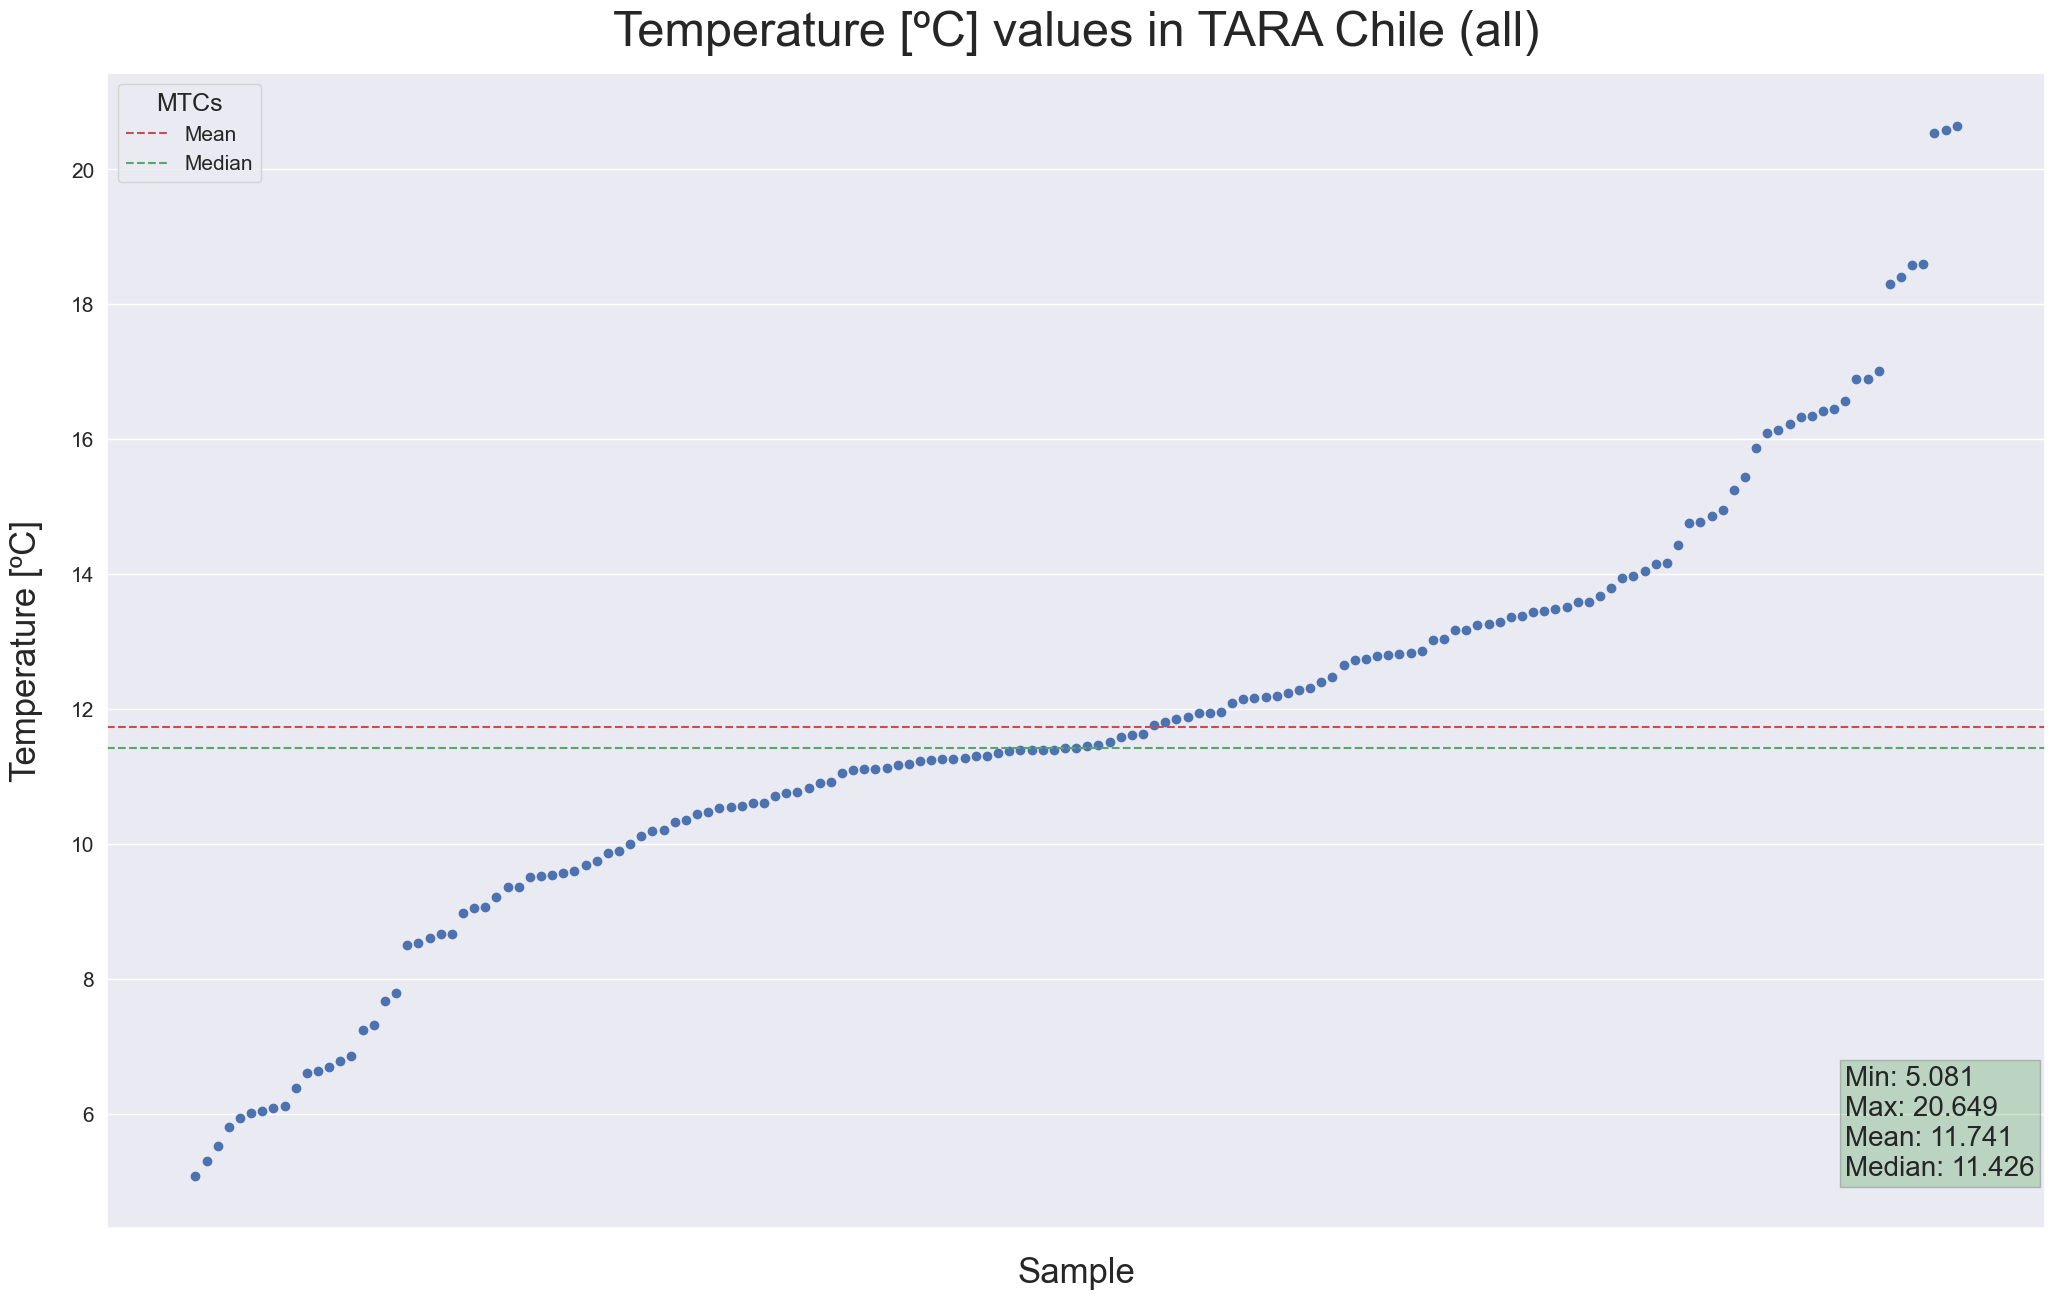

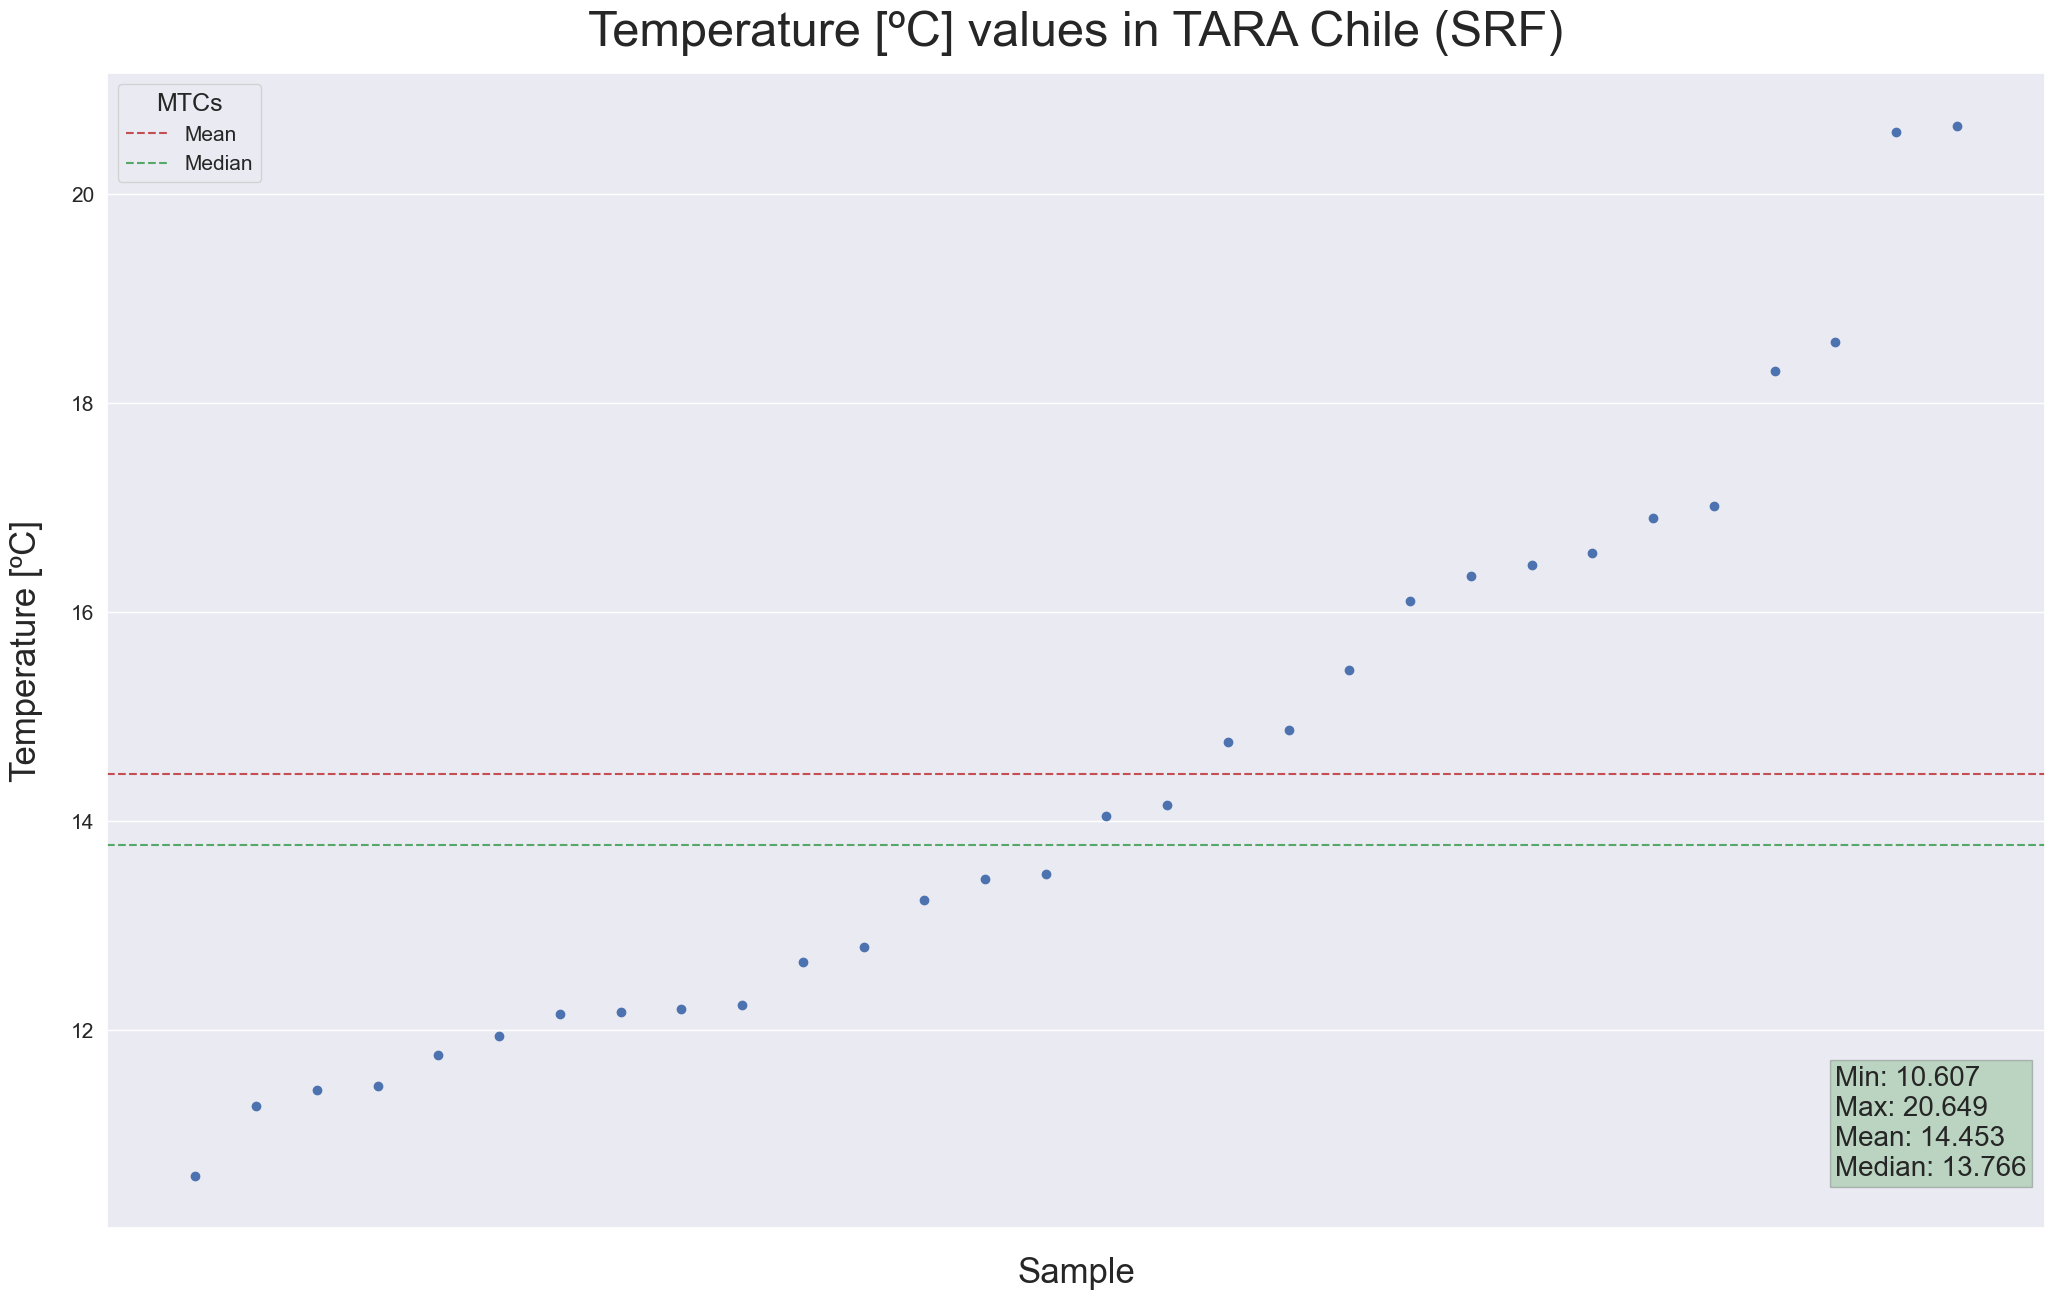

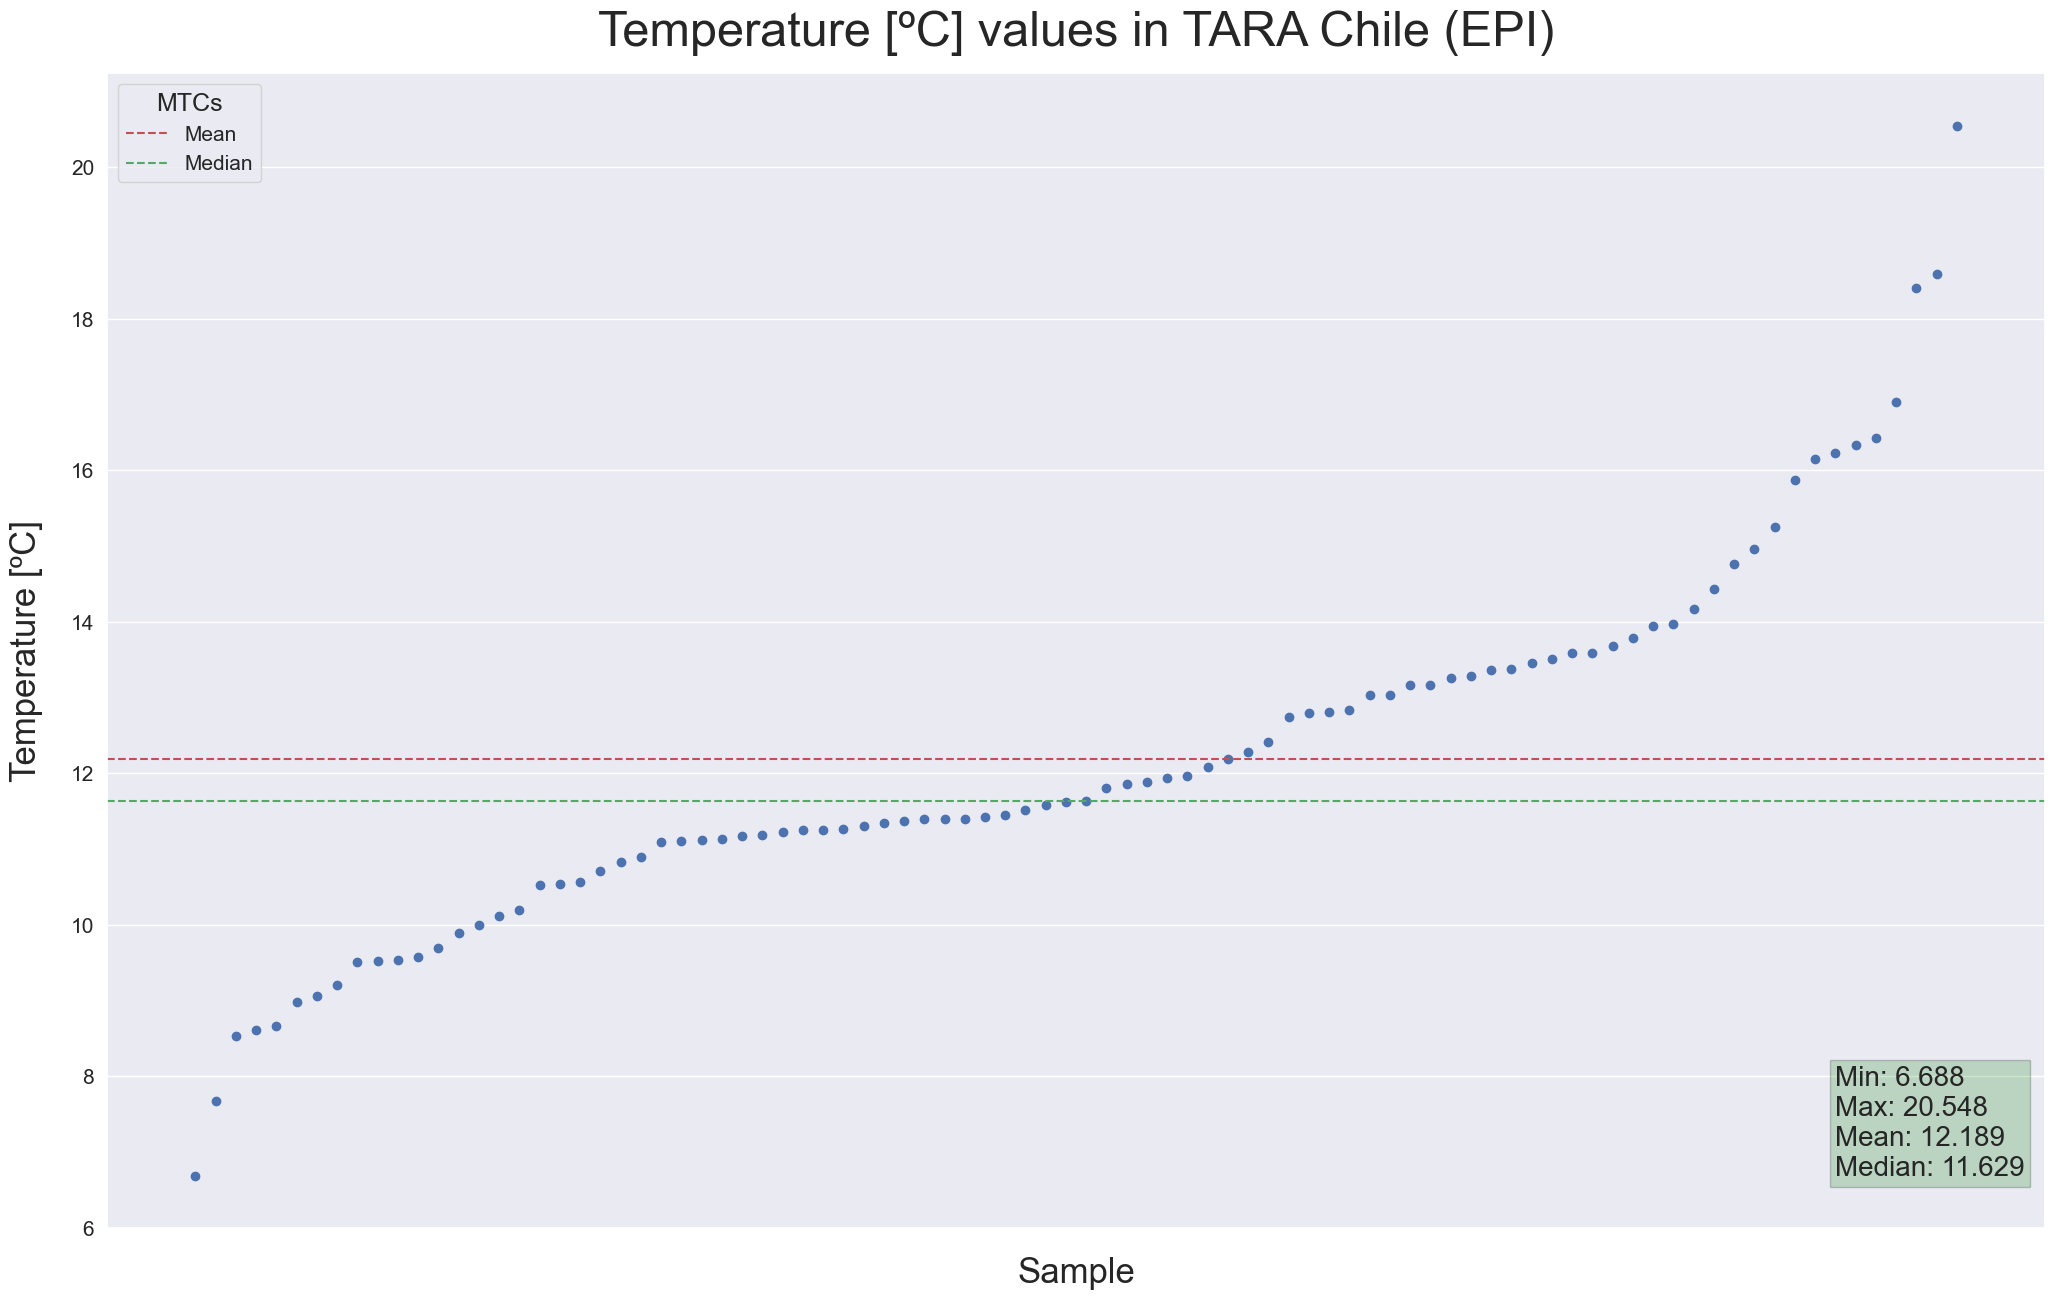

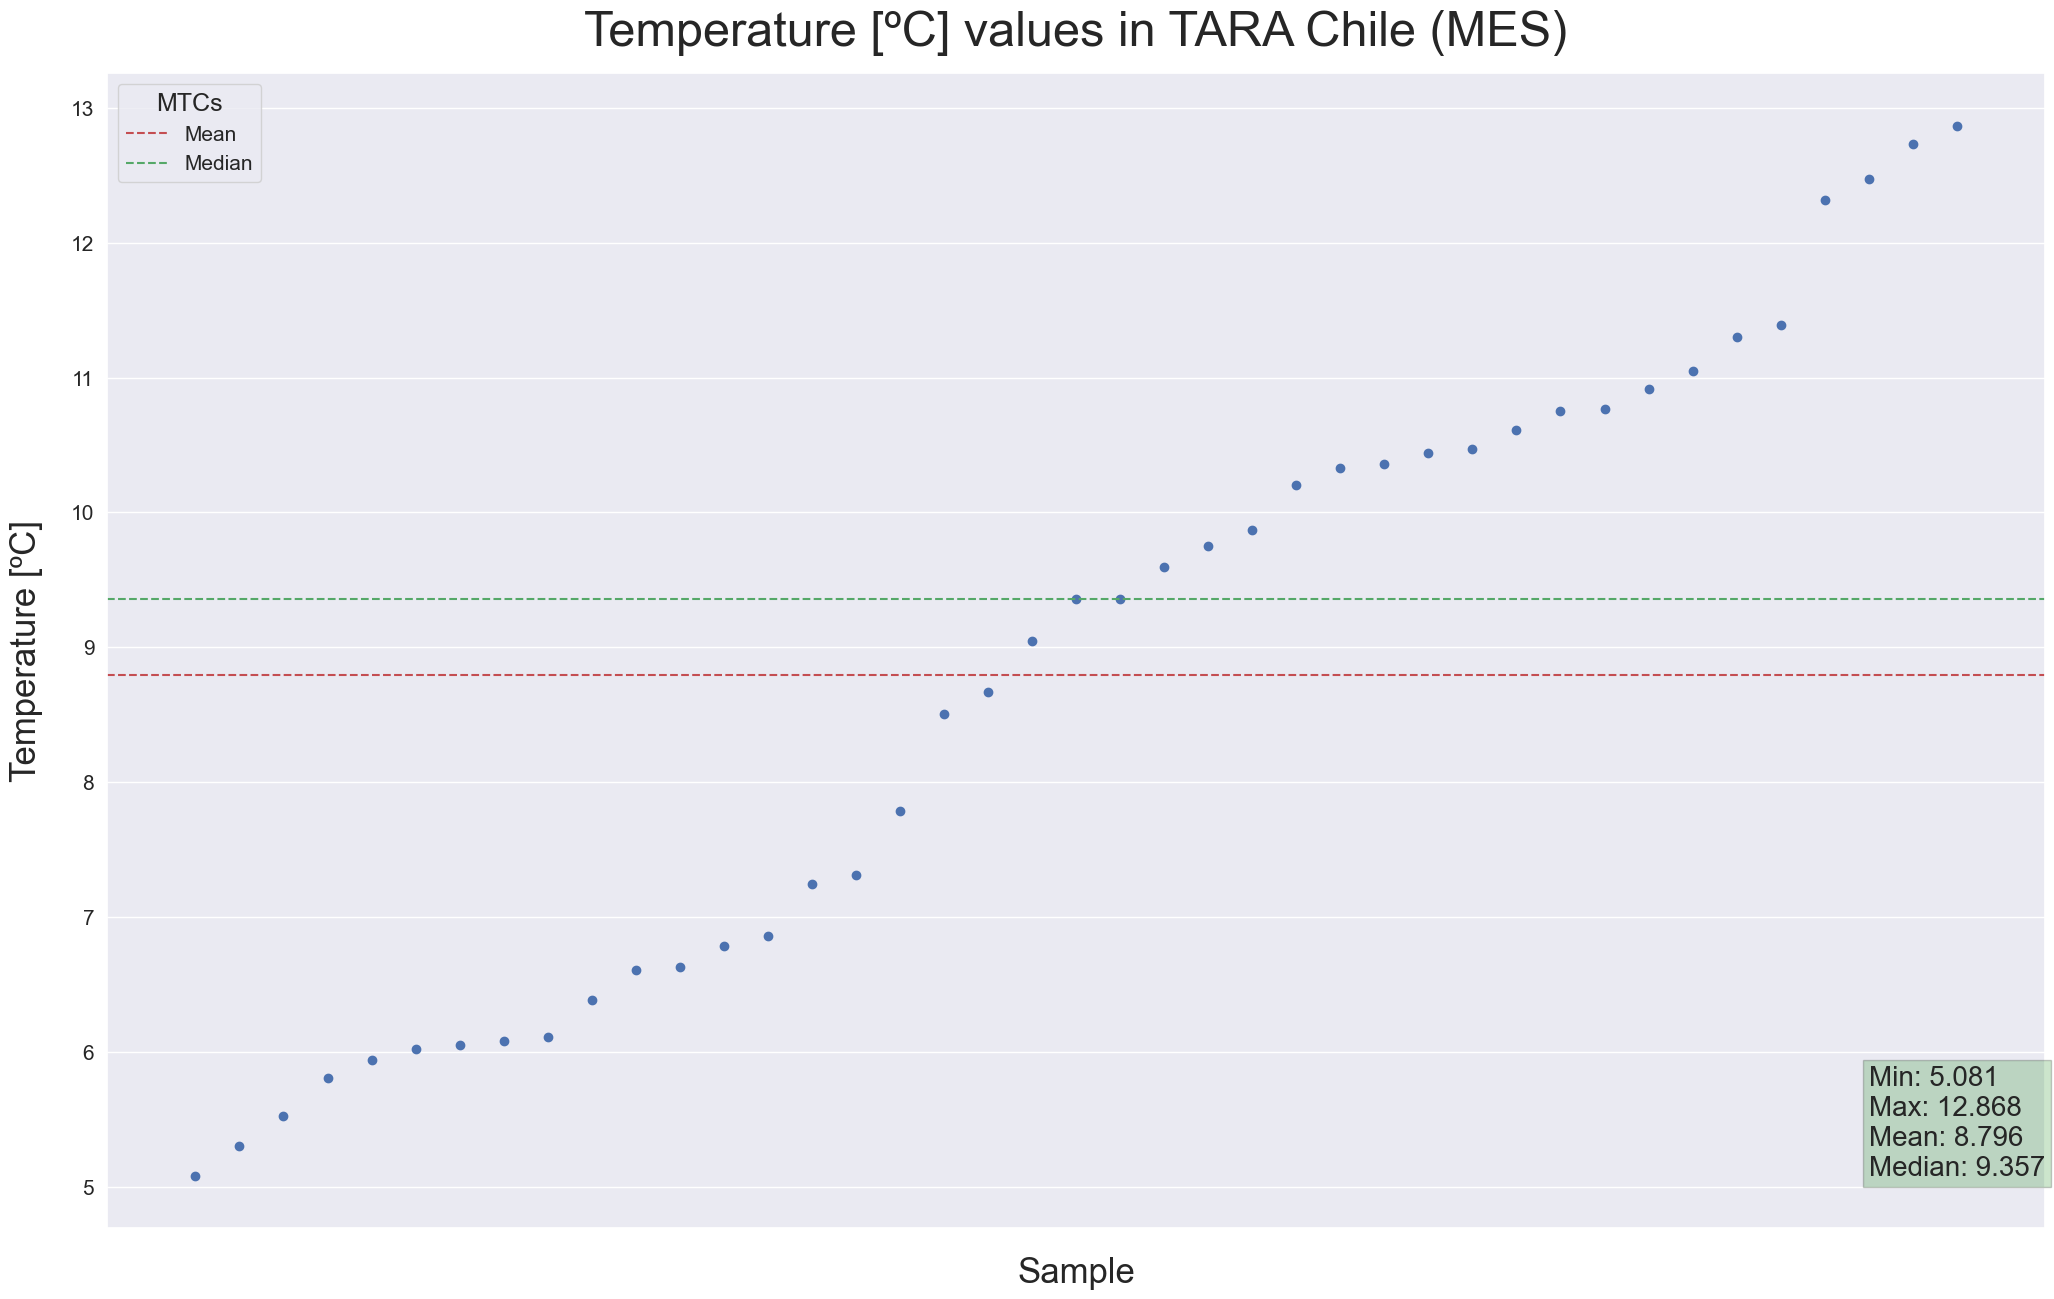

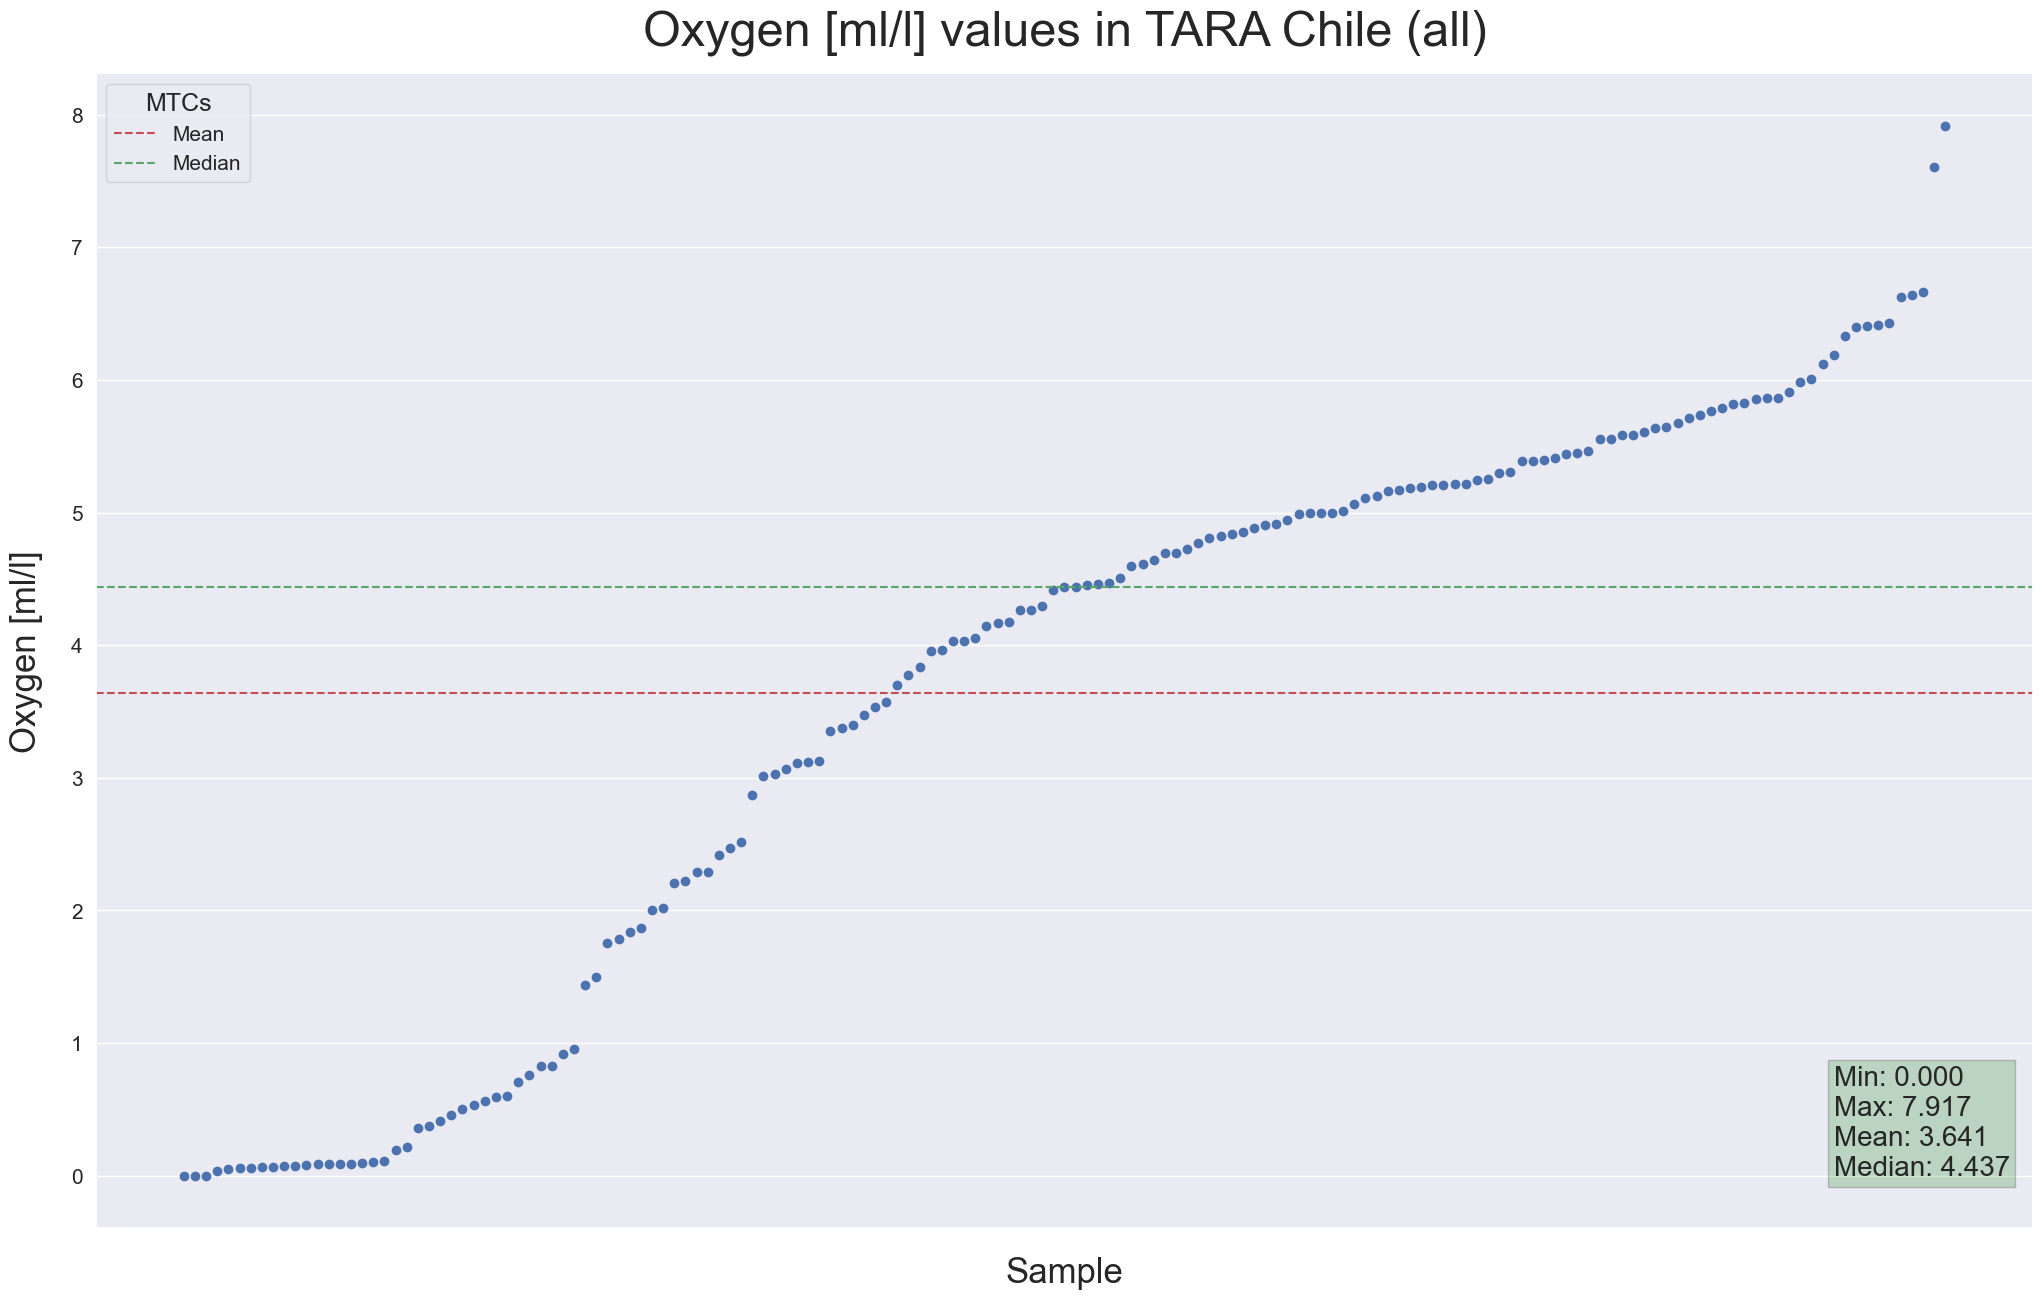

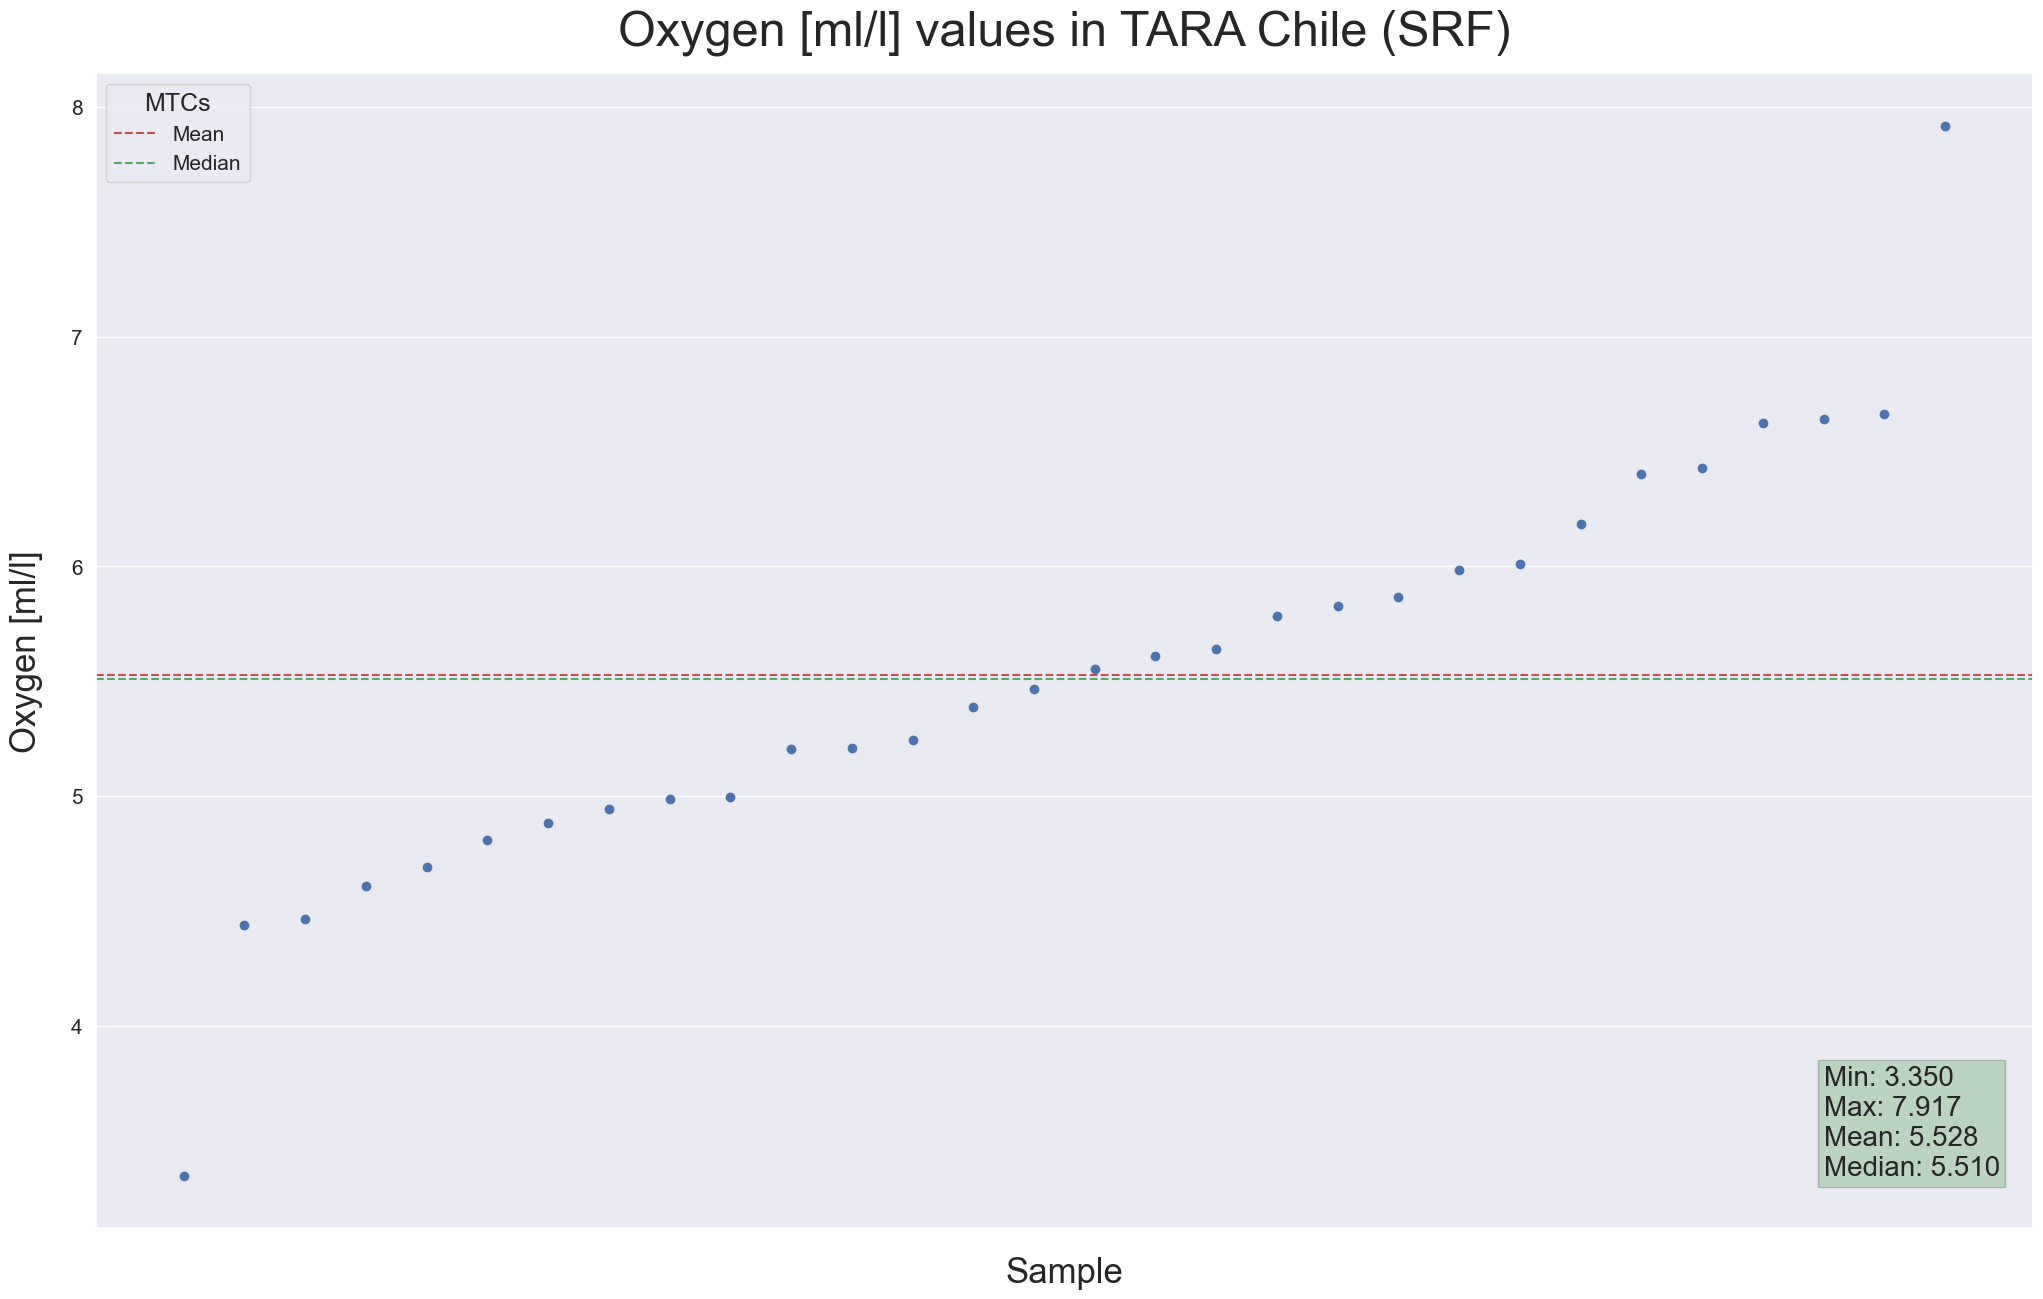

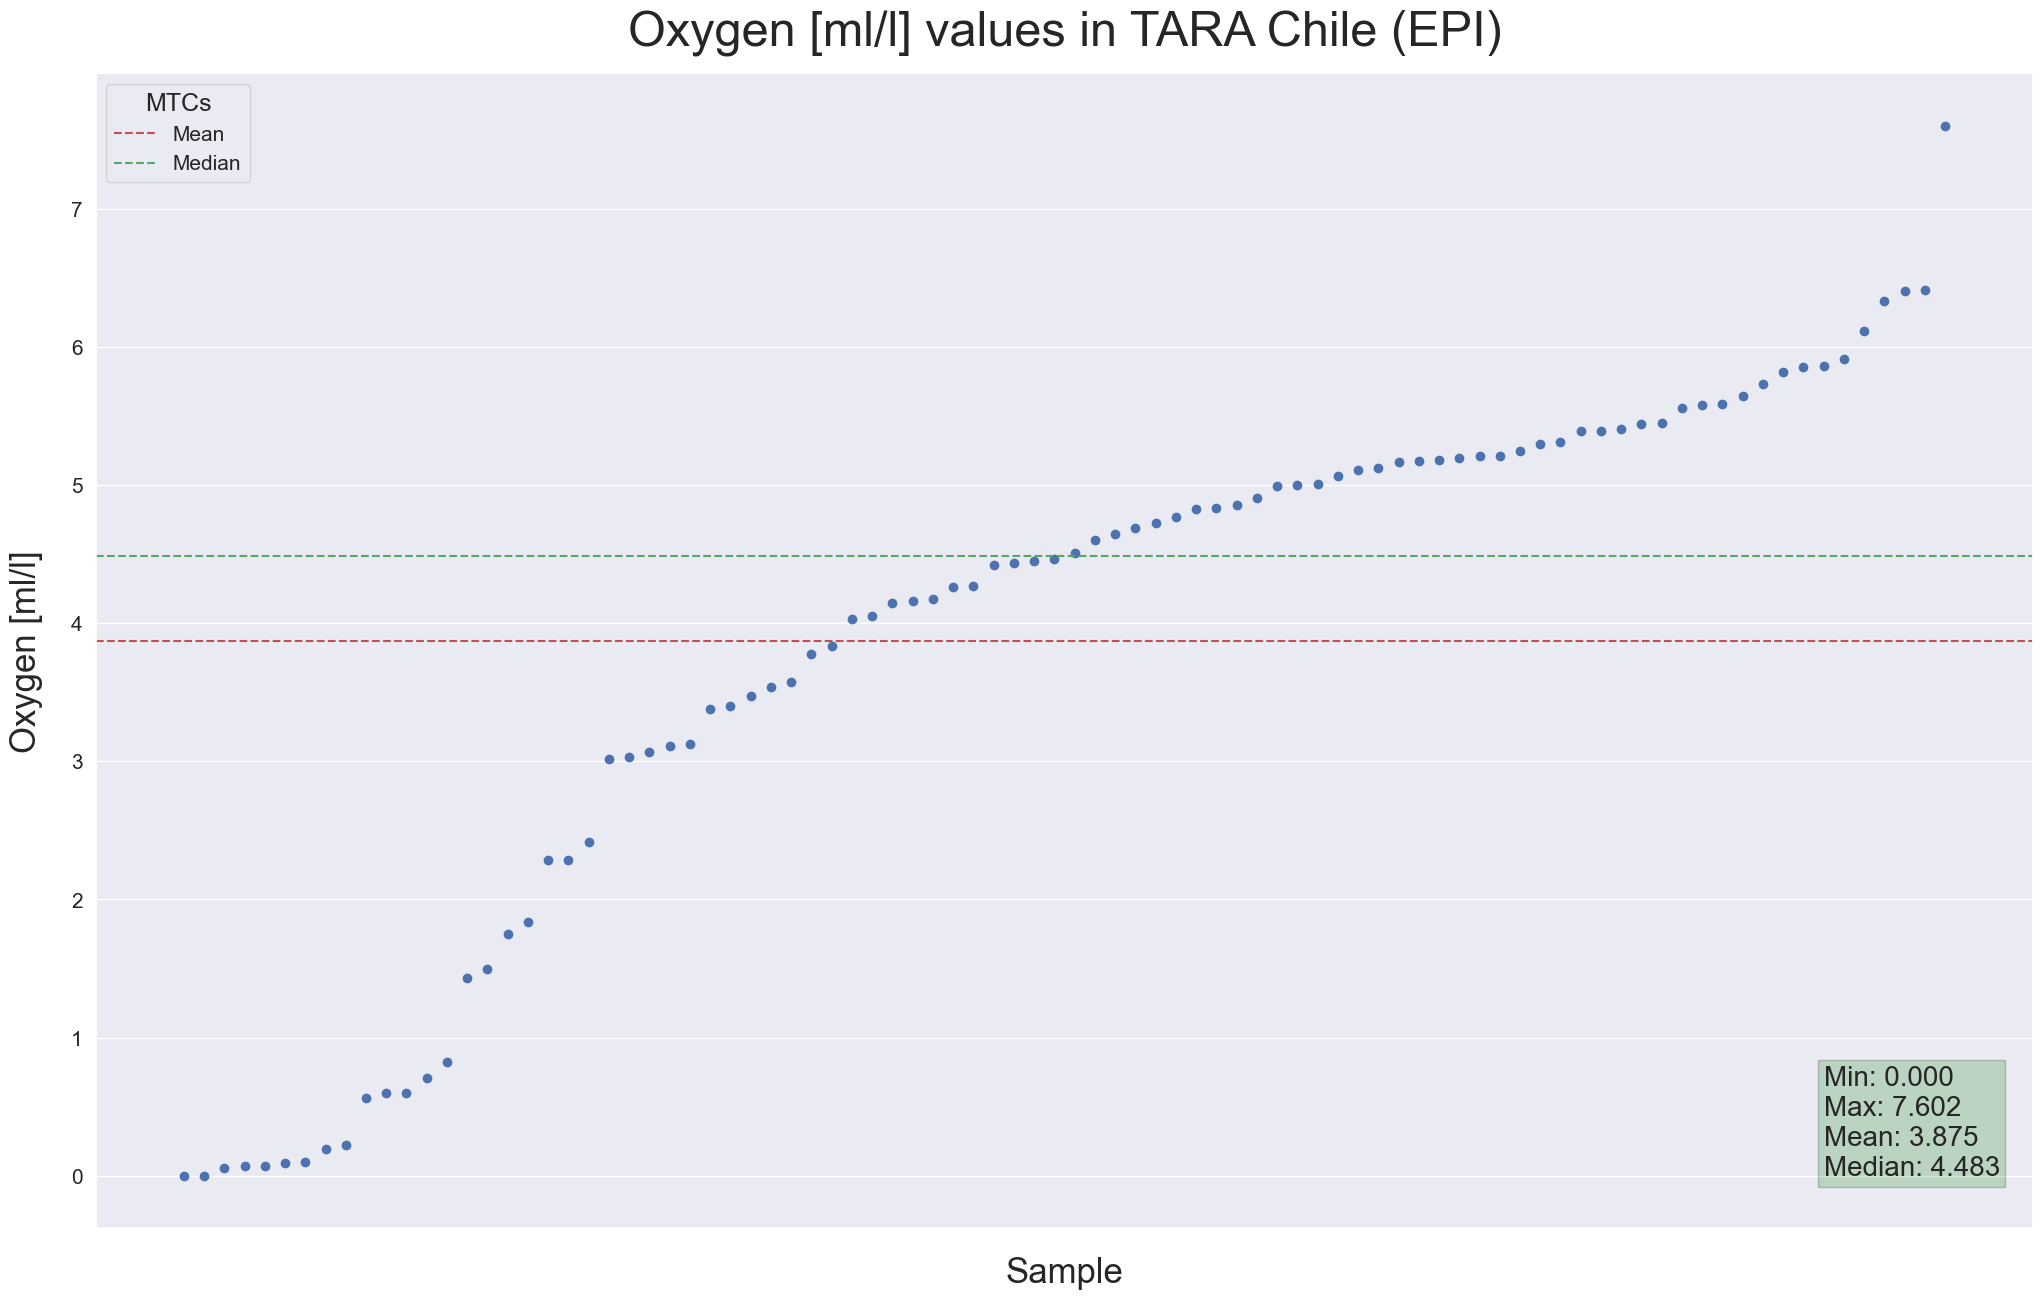

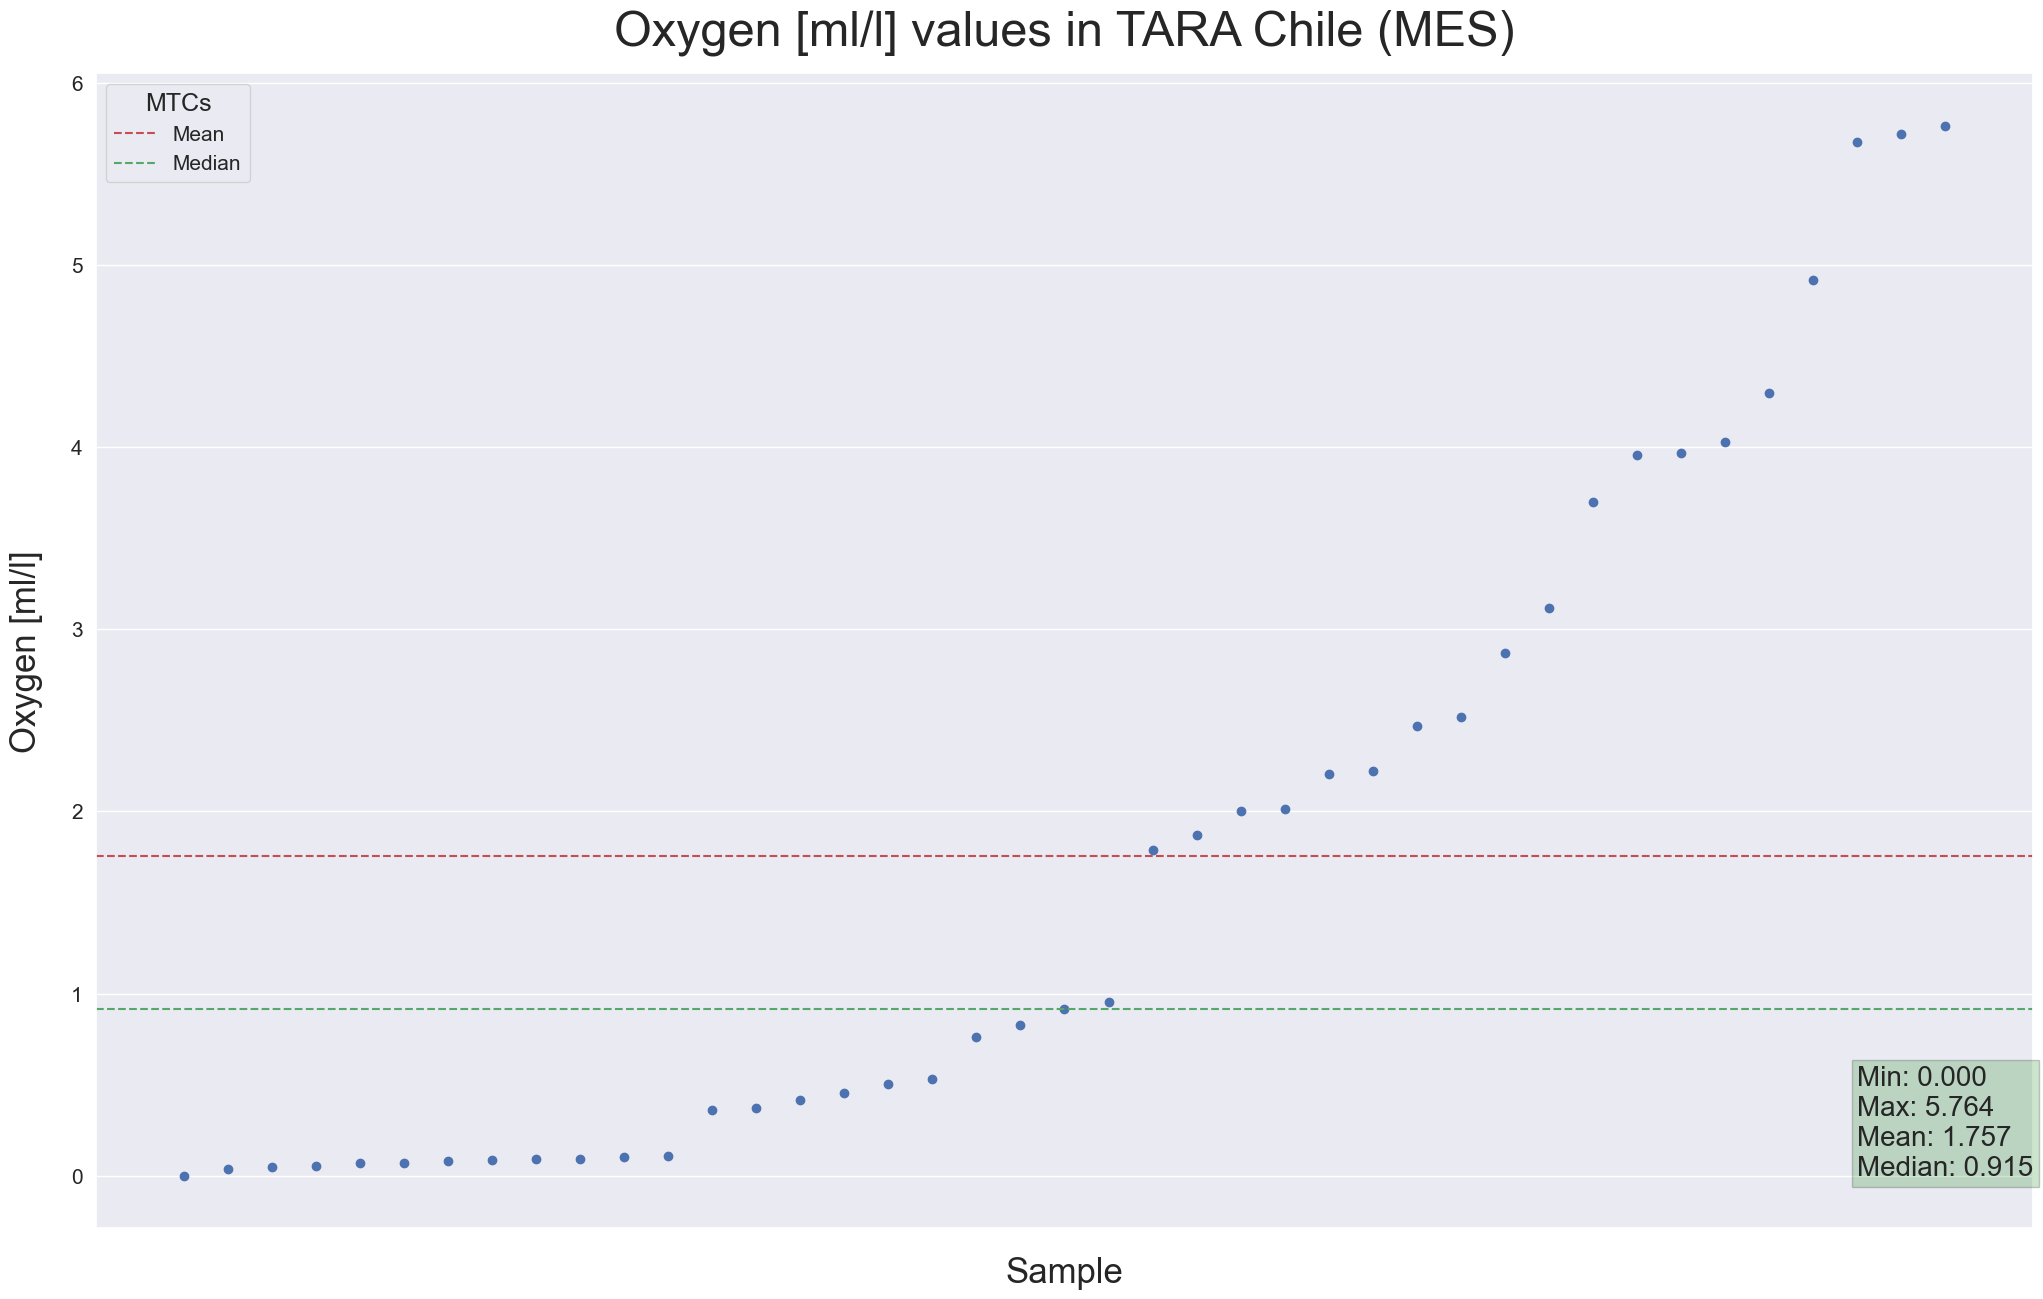

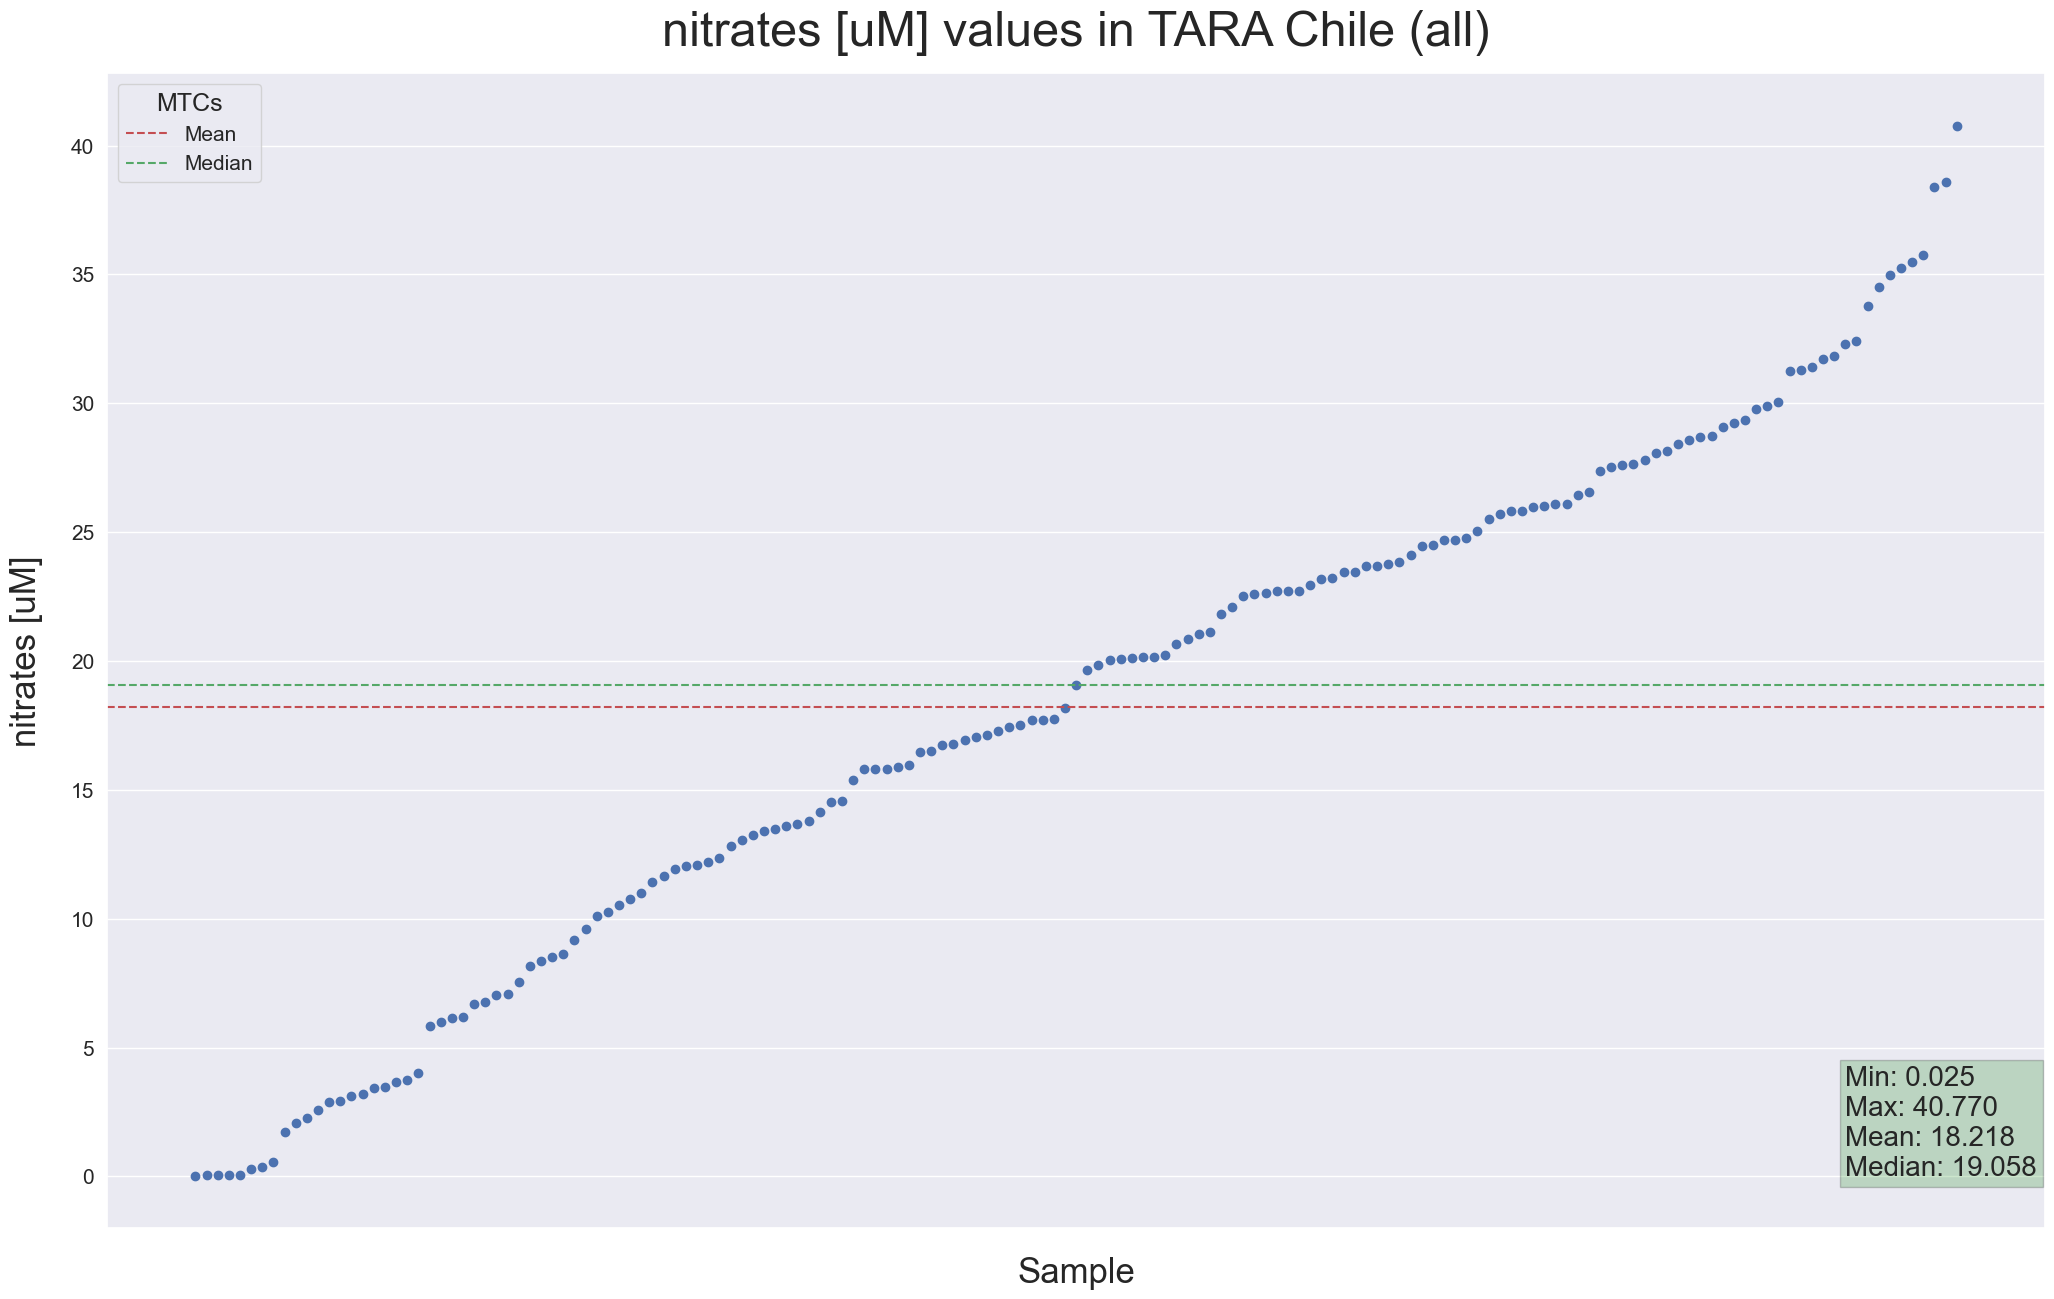

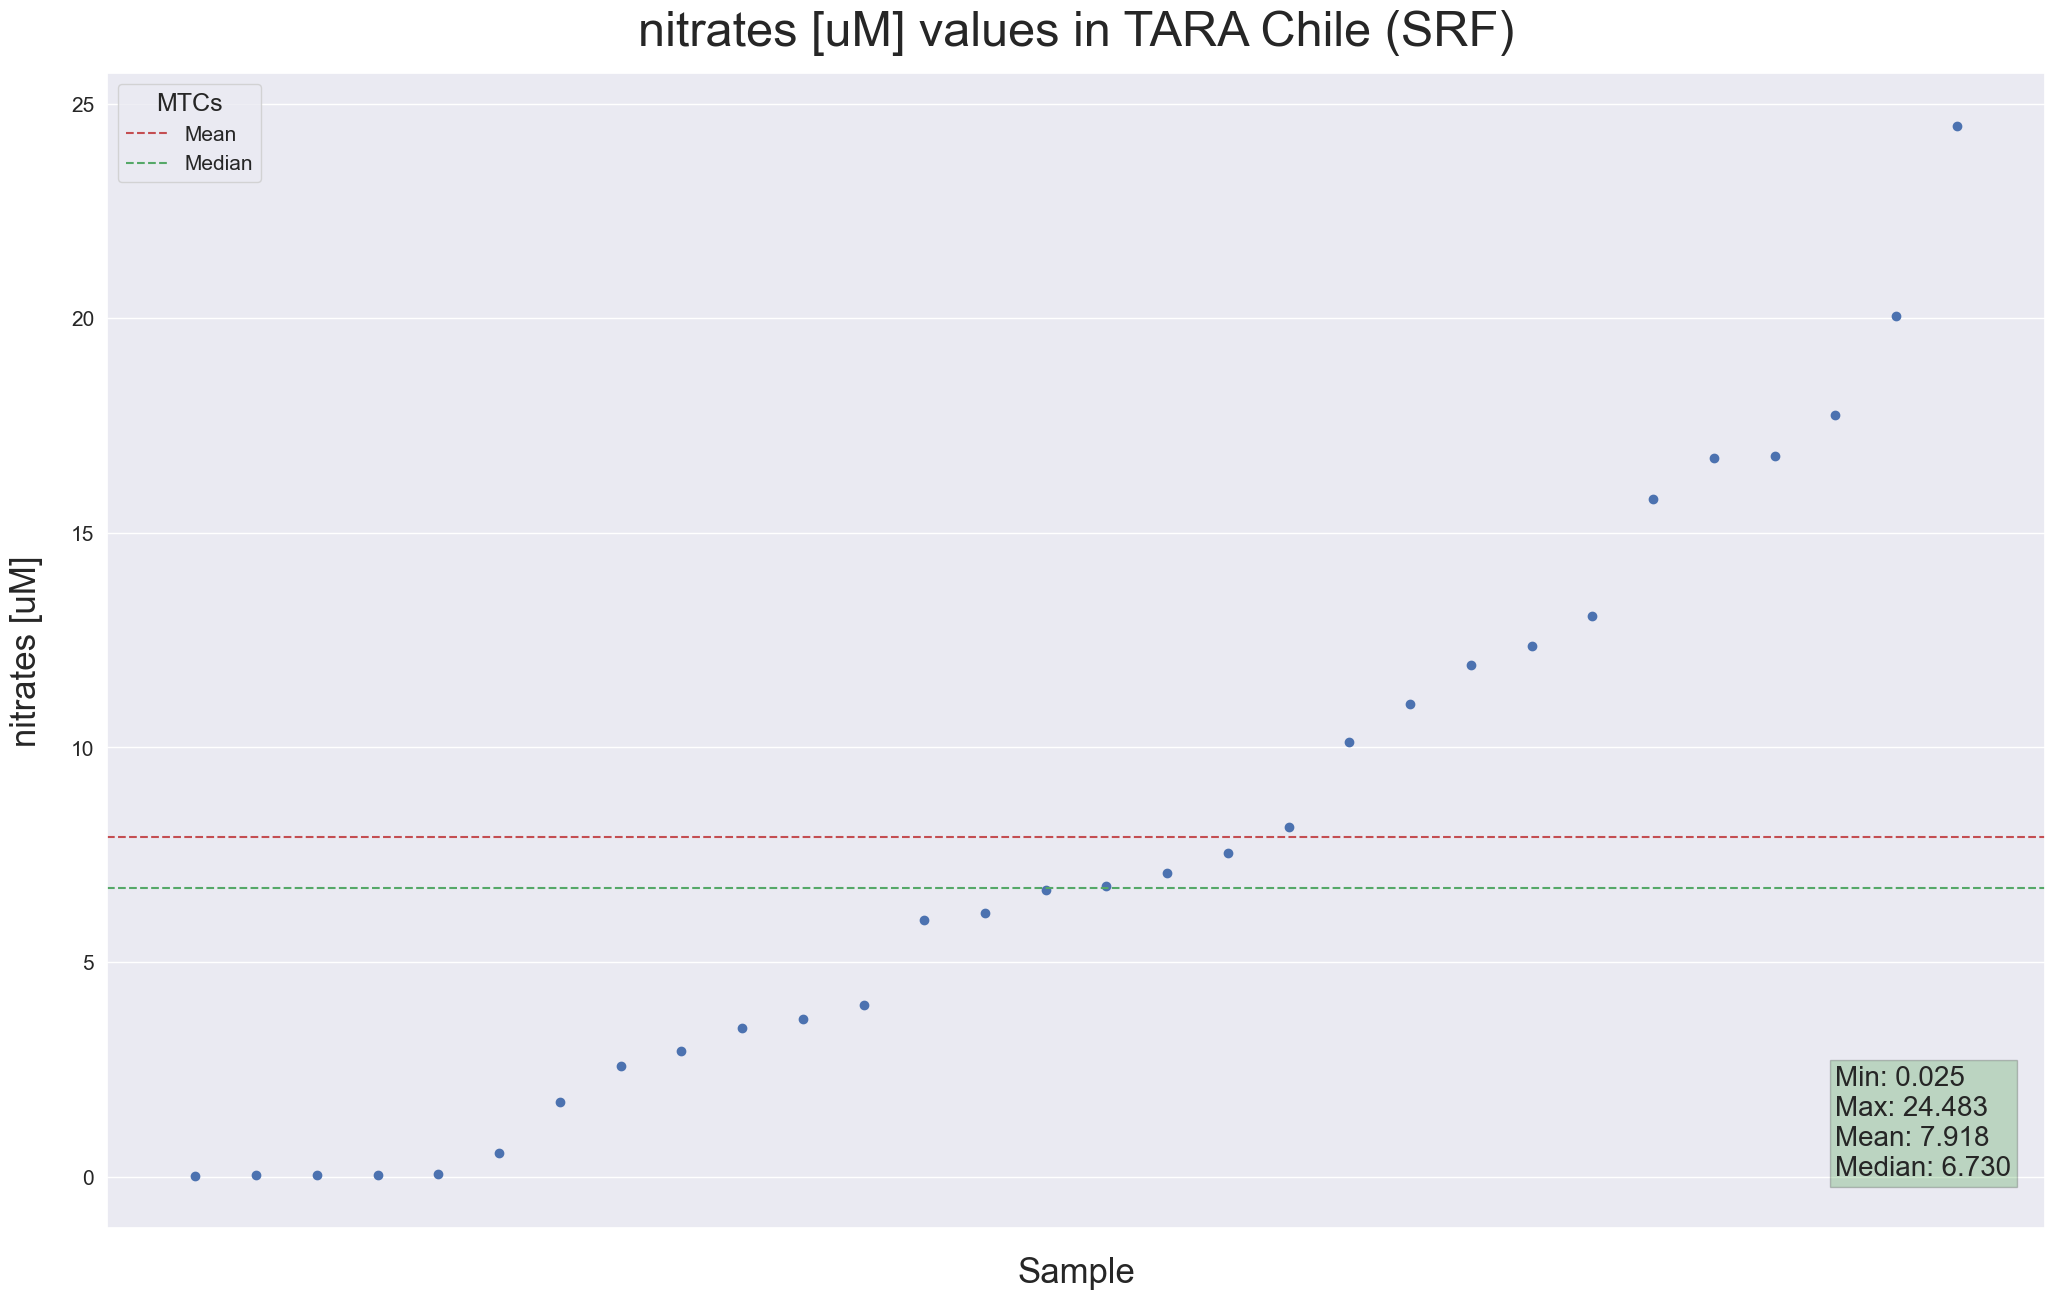

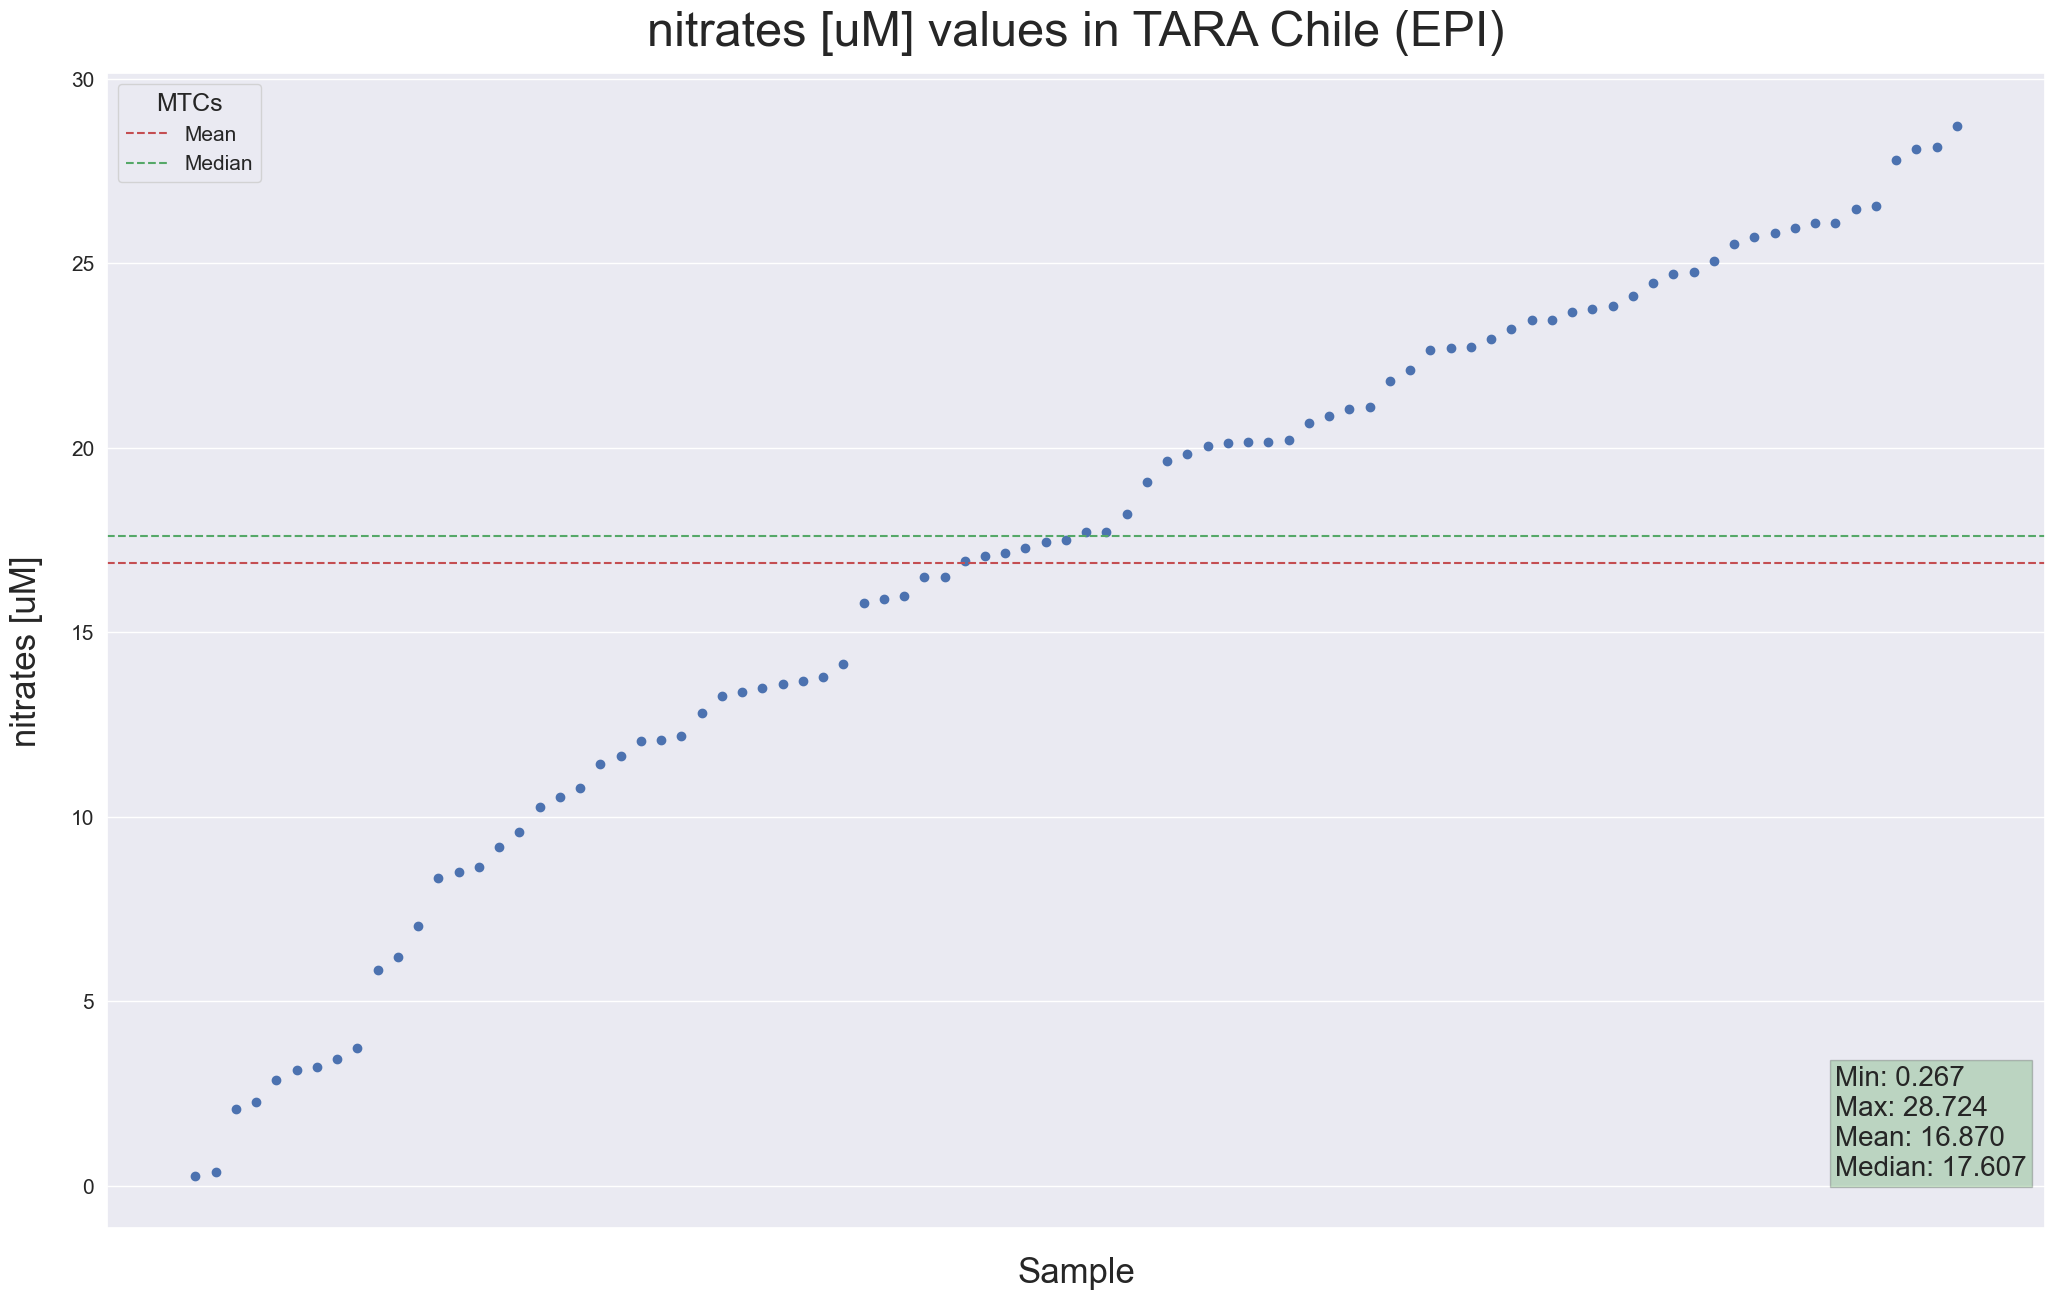

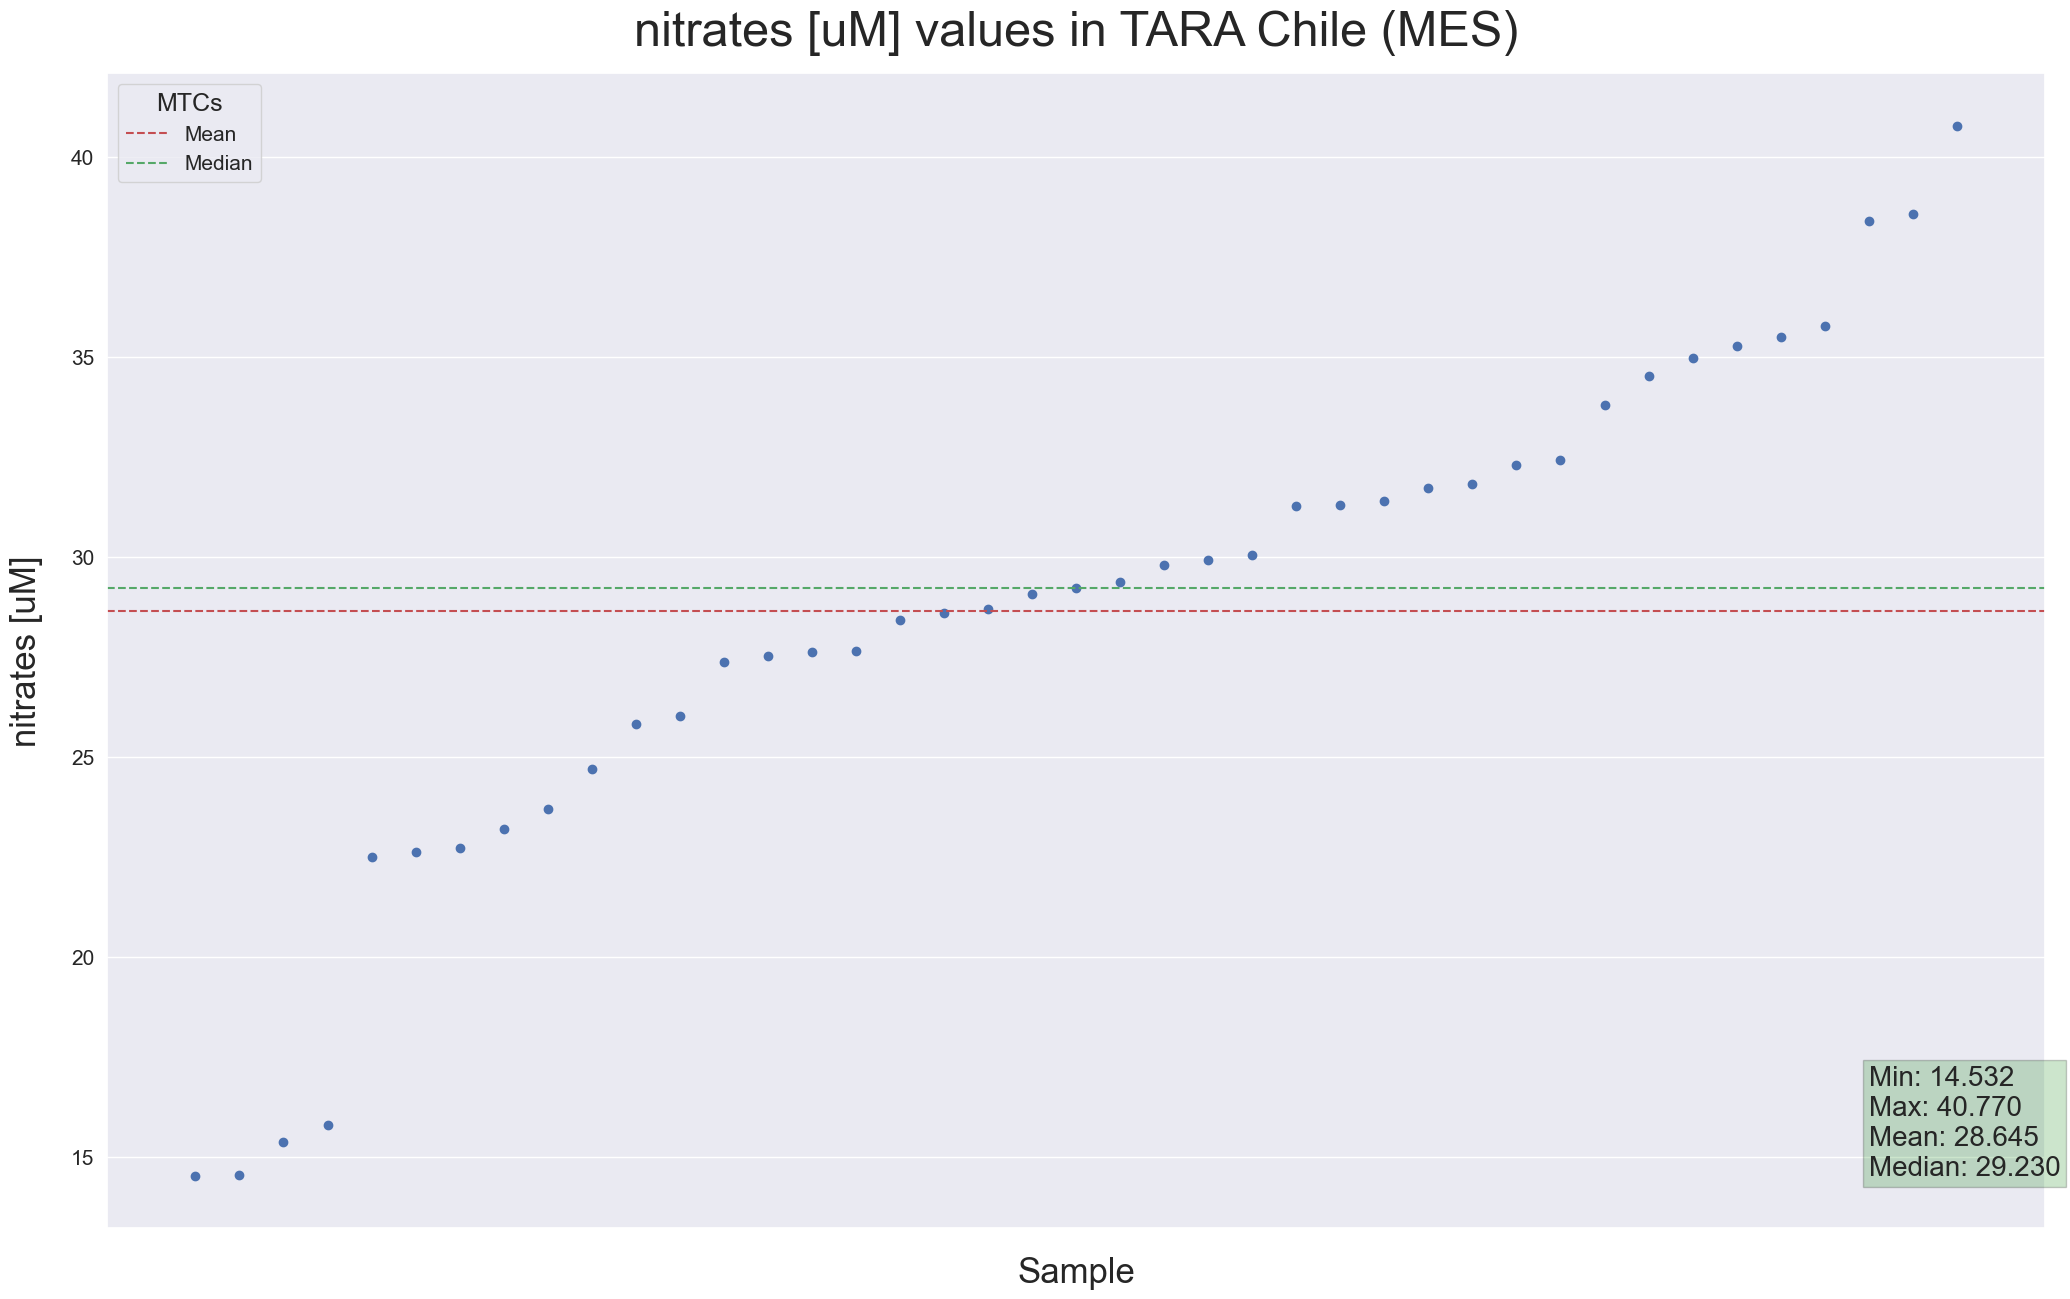

In [28]:
xvals = {'all': 148, 'SRF': 27, 'MES': 38, 'EPI': 81}
spaces = {'Temperature [ºC]':5,'Oxygen [ml/l]':7,'nitrates [uM]':5}
for col in md_df.columns:
    if col != 'Depth level':
        space = spaces[col]
        xval = xvals['all']
        data = md_df[col].sort_values()
        fig, ax = plt.subplots(figsize = (25,15))
        ax.set_title(f'{col} values in TARA Chile (all)', fontsize = 35, pad = 20)
        ax.set_xticks([])
        plt.yticks(fontsize = 15)
        plt.axhline(data.mean(), linestyle='--', color = 'r', label = 'Mean')
        plt.axhline(data.median(), linestyle='--', color = 'g', label = 'Median')
        ax.set_ylabel(f'{col}', fontsize = 25,labelpad=20)
        ax.set_xlabel('Sample', fontsize = 25,labelpad=20)
        ax.legend(title="MTCs", fontsize = 15, title_fontsize = 18)
        plt.text(xval, data.min(), f'Min: {data.min():.3f}\nMax: {data.max():.3f}\nMean: {data.mean():.3f}\nMedian: {data.median():.3f}', fontsize = 20, bbox = dict(facecolor = 'green', alpha = 0.2, ec = 'black'))
        plt.scatter(data.index,data)
        sns.set(style='darkgrid')
        path = f'../03_results/out_ch_data_analysis/{col[:-space]}_all'
        plt.savefig(path)
        for depth in md_df['Depth level'].unique():
            #plot by depth level
            xval = xvals[depth]
            data = (md_df[md_df['Depth level'] == depth])[col].sort_values()
            fig, ax = plt.subplots(figsize = (25,15))
            ax.set_title(f'{col} values in TARA Chile ({depth})', fontsize = 35, pad = 20)
            ax.set_xticks([])
            plt.yticks(fontsize = 15)
            plt.axhline(data.mean(), linestyle='--', color = 'r', label = 'Mean')
            plt.axhline(data.median(), linestyle='--', color = 'g', label = 'Median')
            ax.set_ylabel(f'{col}', fontsize = 25,labelpad=20)
            ax.set_xlabel('Sample', fontsize = 25,labelpad=20)
            ax.legend(title="MTCs", fontsize = 15, title_fontsize = 18)
            plt.text(xval, data.min(), f'Min: {data.min():.3f}\nMax: {data.max():.3f}\nMean: {data.mean():.3f}\nMedian: {data.median():.3f}', fontsize = 20, bbox = dict(facecolor = 'green', alpha = 0.2, ec = 'black'))
            plt.scatter(data.index,data)
            sns.set(style='darkgrid')
            path = f'../03_results/out_ch_data_analysis/{col[:-4]}_{depth}'
            plt.savefig(path)

In [ ]:
md_df['Depth level'].unique()

In [ ]:
data = nitrates.sort_values()
fig, ax = plt.subplots(figsize = (25,15))

ax.set_title('Nitrate values in TARA Chile', fontsize = 35, pad = 20)
ax.set_xticks([])
plt.yticks(fontsize = 15)
plt.axhline(data.mean(), linestyle='--', color = 'r', label = 'Mean')
plt.axhline(data.median(), linestyle='--', color = 'g', label = 'Median')
ax.set_ylabel('Nitrate [uM]', fontsize = 25,labelpad=20)
ax.set_xlabel('Sample', fontsize = 25,labelpad=20)
ax.legend(title="MTCs", fontsize = 15, title_fontsize = 18)
plt.text(138, 5.4, f'Min: {data.min():.3f}\nMax: {data.max():.3f}\nMean: {data.mean():.3f}\nMedian: {data.median():.3f}', fontsize = 20, bbox = dict(facecolor = 'green', alpha = 0.2, ec = 'black'))
plt.scatter(data.index,nitrates.sort_values())
sns.set(style='darkgrid')
plt.show()


In [ ]:
data = md_df['Oxygen [ml/l]'].sort_values()
fig, ax = plt.subplots(figsize = (25,15))

ax.set_title('Oxygen values in TARA Chile', fontsize = 35, pad = 20)
ax.set_xticks([])
plt.yticks(fontsize = 15)
plt.axhline(data.mean(), linestyle='--', color = 'r', label = 'Mean')
plt.axhline(data.median(), linestyle='--', color = 'g', label = 'Median')
ax.set_ylabel('Oxygen [ml/l]', fontsize = 25,labelpad=20)
ax.set_xlabel('Sample', fontsize = 25,labelpad=20)
ax.legend(title="MTCs", fontsize = 15, title_fontsize = 18)
plt.text(138, 0.1, f'Min: {data.min():.3f}\nMax: {data.max():.3f}\nMean: {data.mean():.3f}\nMedian: {data.median():.3f}', fontsize = 20, bbox = dict(facecolor = 'green', alpha = 0.2, ec = 'black'))
plt.scatter(data.index,data)
sns.set(style='darkgrid')
plt.show()


In [ ]:
data = md_df['Temperature [ºC]'].sort_values()
fig, ax = plt.subplots(figsize = (25,15))

ax.set_title('Temperature values in TARA Chile', fontsize = 35, pad = 20)
ax.set_xticks([])
plt.yticks(fontsize = 15)
plt.axhline(data.mean(), linestyle='--', color = 'r', label = 'Mean')
plt.axhline(data.median(), linestyle='--', color = 'g', label = 'Median')
ax.set_ylabel('Temperature [ºC]', fontsize = 25,labelpad=20)
ax.set_xlabel('Sample', fontsize = 25,labelpad=20)
ax.legend(title="MTCs", fontsize = 15, title_fontsize = 18)
plt.text(138, 6.2, f'Min: {data.min():.3f}\nMax: {data.max():.3f}\nMean: {data.mean():.3f}\nMedian: {data.median():.3f}', fontsize = 20, bbox = dict(facecolor = 'green', alpha = 0.2, ec = 'black'))
plt.scatter(data.index,data)
sns.set(style='darkgrid')
plt.show()


In [ ]:
s = 'abcdef'
s[:-1]